# Library
Here we will import the necessary libiraries used in this implementation

In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mlxtend.evaluate import bias_variance_decomp
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import time
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import scikitplot as skplt
import seaborn as sns

from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function

# Import dataset
We will import the heart disease dataset from kaggle and deal with the object data type.

In [2]:
df = pd.read_csv("heart.csv")
df.info()
X = df.drop(["HeartDisease"], axis=1)
y = df["HeartDisease"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [3]:
numerical= df.drop(['HeartDisease'], axis=1).select_dtypes('number').columns

categorical = df.select_dtypes('object').columns

print(f'Numerical Columns:  {df[numerical].columns}')
print('\n')
print(f'Categorical Columns: {df[categorical].columns}')

Numerical Columns:  Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')


Categorical Columns: Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


# Test models
We will use make_column_transformer to process the categorical data attributes with one hot encoding and numerical data attributes with standard scaler or MinMax scaler respectively.

## Gradient Boosting Classifier from sklearn

### Gradient Boosting Classifier with/without Scaler
We would only like to know the influence of Scaler, and keep the rest hyperparameter of the model

In [11]:
accuracy =[]
scaler =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()

#No scaler
col_trans_none = make_column_transformer((oh,categorical),remainder='passthrough')  

model = GradientBoostingClassifier(random_state=100)
pipe = make_pipeline(col_trans_none, model)
pipe.fit(X_train, y_train)
y_pred_none = pipe.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred_none),4))
# print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

#using standard scaler
st = StandardScaler()
col_trans_st = make_column_transformer((oh,categorical),(st,numerical))  

model = GradientBoostingClassifier(random_state=100)
pipe = make_pipeline(col_trans_st, model)
pipe.fit(X_train, y_train)
y_pred_st = pipe.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred_st),4))

#using MinMax scaler
mm = MinMaxScaler()
col_trans_mm = make_column_transformer((oh,categorical),(mm,numerical))  

model = GradientBoostingClassifier(random_state=100)
pipe = make_pipeline(col_trans_mm, model)
pipe.fit(X_train, y_train)
y_pred_mm = pipe.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred_mm),4))

scaler = ['None', 'Standard', 'MinMax']
GBC_result_df = pd.DataFrame({'Accuracy':accuracy}, index=scaler)
GBC_result_df

,Accuracy
None,0.8859
Standard,0.8859
MinMax,0.8859


### Testing accuracy at different depths of Gradient Boosting
Since the dataset scaled or not does not change the performance, we did not use scaler for shorter runtime

In [23]:
accuracy =[]
runtime =[]

depth = list(np.linspace(1,  10, 10))

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#No scaler
col_trans_none = make_column_transformer((oh,categorical),remainder='passthrough')  



for i in depth:
    start_time = time.time()
    model = GradientBoostingClassifier(max_depth=i, random_state=100)
    pipe = make_pipeline(col_trans_none, model)
    pipe.fit(X_train, y_train)
    y_pred_none = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred_none),4))
    runtime.append(time.time() - start_time)

#print("Depth", type(depth))
#print("Accuracy", type(accuracy))
#print("Runtime", type(runtime))
GBC_result_df = pd.DataFrame({'Depth':depth, 'Accuracy':accuracy,'Runtime':runtime})
GBC_result_df  

,Depth,Accuracy,Runtime
0,1.0,0.8641,0.170060
1,2.0,0.8750,0.218743
2,3.0,0.8859,0.339905
3,4.0,0.8859,0.408102
4,5.0,0.8750,0.567580
5,6.0,0.8696,0.667892
6,7.0,0.8641,0.793777
7,8.0,0.8587,1.171301
8,9.0,0.8315,1.267350
9,10.0,0.8261,1.389026


Based on the results of "number of trees vs accuracy", we can see that the number of trees is not the more the better. So we choose the best number of trees, which is around 20. And then test the influence of the depth.

In [51]:
accuracy =[]
runtime =[]

depth = list(np.linspace(1,  10, 10))

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#No scaler
col_trans_none = make_column_transformer((oh,categorical),remainder='passthrough')  



for i in depth:
    start_time = time.time()
    model = GradientBoostingClassifier(n_estimators=23, max_depth=i, random_state=100)
    pipe = make_pipeline(col_trans_none, model)
    pipe.fit(X_train, y_train)
    y_pred_none = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred_none),4))
    runtime.append(time.time() - start_time)

#print("Depth", type(depth))
#print("Accuracy", type(accuracy))
#print("Runtime", type(runtime))
GBC_result_df = pd.DataFrame({'Depth':depth, 'Accuracy':accuracy,'Runtime':runtime})
GBC_result_df  

,Depth,Accuracy,Runtime
0,1.0,0.8043,0.034906
1,2.0,0.8424,0.047914
2,3.0,0.8804,0.050823
3,4.0,0.8913,0.063875
4,5.0,0.8696,0.078743
5,6.0,0.8424,0.095790
6,7.0,0.8424,0.135593
7,8.0,0.8207,0.168593
8,9.0,0.8043,0.163480
9,10.0,0.8098,0.167634


### Testing accuracy with different number of trees for Gradient Boosting
Since the last results show that the depth of 3 and 4 give us best score and the depth of 3 has shorted runtime, we will choose the depth of 3 for the rest testing.

Text(0, 0.5, 'Accuracy')

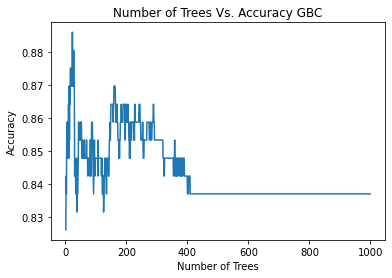

In [32]:
accuracy =[]
runtime =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#No scaler
col_trans_none = make_column_transformer((oh,categorical),remainder='passthrough')

n_est = 1000
for n in range(1, n_est):
    model = GradientBoostingClassifier(n_estimators=n, learning_rate=1.0, max_depth=3, random_state=100)
    pipe = make_pipeline(col_trans_none, model)
    pipe.fit(X_train, y_train)
    y_pred_none = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred_none),4))

GBC_result_df = pd.DataFrame({'n_est':range(1, n_est), 'Accuracy':accuracy})
GBC_result_df   

plt.plot(range(1, n_est), accuracy, label = "test_accuracy")
plt.xlabel('Number of Trees')
plt.title("Number of Trees Vs. Accuracy GBC")
plt.ylabel('Accuracy')

In [40]:
GBC_result_df.head(50)

,n_est,Accuracy
0,1,0.8261
1,2,0.8424
2,3,0.8370
3,4,0.8533
4,5,0.8587
5,6,0.8478
6,7,0.8587
7,8,0.8587
8,9,0.8533
9,10,0.8641


### Testing accuracy with different learning rate for Gradient Boosting

,Learning rate,Train_acc,Test_acc
0,0.010000,0.8569,0.8207
1,0.019953,0.8624,0.8207
2,0.039811,0.8719,0.8370
3,0.079433,0.8937,0.8750
4,0.158489,0.9114,0.8696
5,0.316228,0.9482,0.8750
6,0.630957,0.9659,0.8587
7,1.258925,0.9850,0.8370
8,2.511886,0.4074,0.3913
9,5.011872,0.5490,0.5707


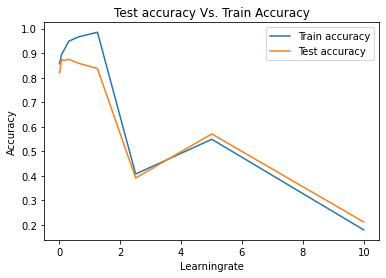

In [46]:
train_acc = []
test_acc = []
lr = list(np.logspace(-2, 1, 11))

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

for n in lr:
    model = GradientBoostingClassifier(n_estimators=22, learning_rate=n, max_depth=3, random_state=100)
    pipe = make_pipeline(col_trans_none, model)
    pipe.fit(X_train, y_train)
    train_acc.append(round(pipe.score(X_train, y_train),4))
    test_acc.append(round(pipe.score(X_test, y_test),4))

plt.plot(lr , train_acc, label = "train_accuracy")
plt.plot(lr , test_acc, label = "test_accuracy")
plt.legend(["Train accuracy", "Test accuracy"])
plt.title("Test accuracy Vs. Train Accuracy")
plt.xlabel('Learningrate')
plt.ylabel('Accuracy')

GBC_result_df = pd.DataFrame({'Learning rate':lr, 'Train_acc':train_acc, 'Test_acc':test_acc})
GBC_result_df

In [45]:
print(lr)

[0.01, 0.0199526231496888, 0.039810717055349734, 0.07943282347242814, 0.15848931924611134, 0.31622776601683794, 0.630957344480193, 1.2589254117941675, 2.5118864315095797, 5.01187233627272, 10.0]


### Testing accuracy with different max_leaf_nodes for Gradient Boosting

Text(0, 0.5, 'Accuracy')

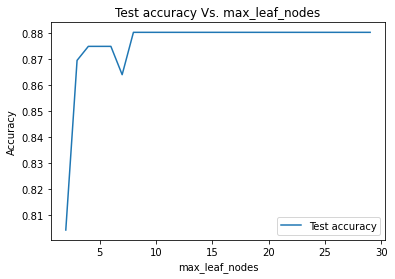

In [68]:
accuracy =[]
runtime =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#No scaler
col_trans_none = make_column_transformer((oh,categorical),remainder='passthrough')

max_leaf_nodes = 30
for n in range(2, max_leaf_nodes):
    start_time = time.time()
    model = GradientBoostingClassifier(n_estimators=23, learning_rate=0.1, max_depth=3,max_leaf_nodes=n, random_state=100)
    pipe = make_pipeline(col_trans_none, model)
    pipe.fit(X_train, y_train)
    y_pred_none = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred_none),4))
    runtime.append(time.time() - start_time)

GBC_result_df = pd.DataFrame({'max_leaf_nodes':range(2, max_leaf_nodes), 'Accuracy':accuracy, 'Runtime':runtime})
GBC_result_df


plt.plot(range(2, max_leaf_nodes) , accuracy, label = "test_accuracy")
plt.legend(["Test accuracy"])
plt.title("Test accuracy Vs. max_leaf_nodes")
plt.xlabel('max_leaf_nodes')
plt.ylabel('Accuracy')

### Testing accuracy with different min_samples_leaf for Gradient Boosting

Text(0, 0.5, 'Accuracy')

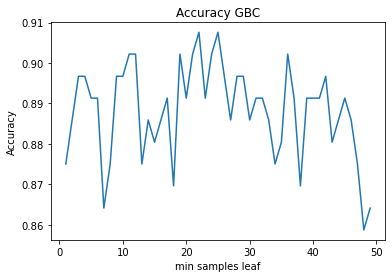

In [94]:
accuracy =[]
runtime =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#No scaler
col_trans_none = make_column_transformer((oh,categorical),remainder='passthrough')

min_samples_leaf = 50
for n in range(1, min_samples_leaf):
    model = GradientBoostingClassifier(n_estimators=23, learning_rate=0.2, max_depth=4, min_samples_leaf=n,random_state=100)
    pipe = make_pipeline(col_trans_none, model)
    pipe.fit(X_train, y_train)
    y_pred_none = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred_none),4))

GBC_result_df = pd.DataFrame({'min_samples_leaf':range(1, min_samples_leaf), 'Accuracy':accuracy})
GBC_result_df   

plt.plot(range(1, min_samples_leaf), accuracy, label = "test_accuracy")
plt.xlabel('min samples leaf')
plt.title("Accuracy GBC")
plt.ylabel('Accuracy')

In [98]:

GBC_result_df[GBC_result_df.Accuracy == GBC_result_df.Accuracy.max()]

,min_samples_leaf,Accuracy
21,22,0.9076
24,25,0.9076


### Testing accuracy with different min_samples_leaf for Gradient Boosting

Text(0, 0.5, 'Accuracy')

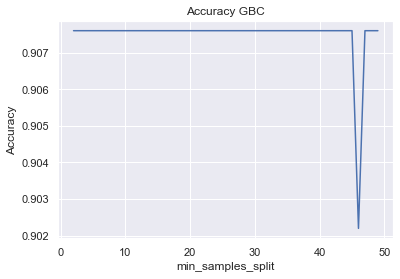

In [133]:
accuracy =[]
runtime =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#No scaler
col_trans_none = make_column_transformer((oh,categorical),remainder='passthrough')

min_samples_split = 50
for n in range(2, min_samples_split):
    model = GradientBoostingClassifier(n_estimators=23, learning_rate=0.2, max_depth=4, min_samples_leaf=22,min_samples_split = n, random_state=100)
    pipe = make_pipeline(col_trans_none, model)
    pipe.fit(X_train, y_train)
    y_pred_none = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred_none),4))

GBC_result_df = pd.DataFrame({'min_samples_split':range(2, min_samples_split), 'Accuracy':accuracy})
GBC_result_df   

plt.plot(range(2, min_samples_split), accuracy, label = "test_accuracy")
plt.xlabel('min_samples_split')
plt.title("Accuracy GBC")
plt.ylabel('Accuracy')

### Testing accuracy with different subsample for Gradient Boosting

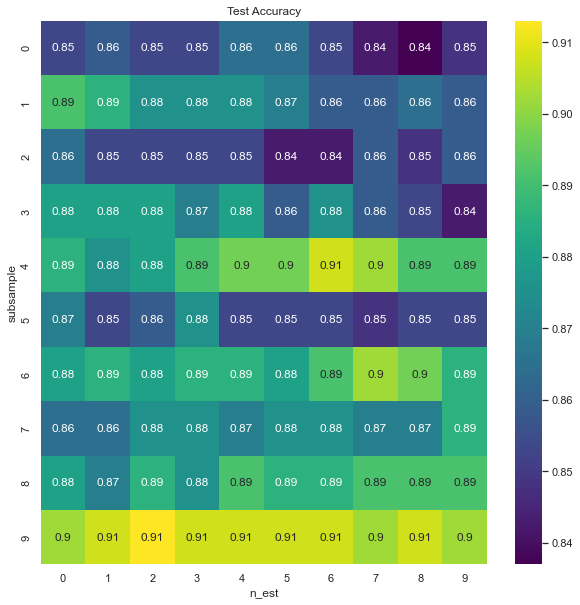

In [128]:

np.random.seed(100)
sns.set()

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#No scaler
col_trans_none = make_column_transformer((oh,categorical),remainder='passthrough')

subsample = np.linspace(0.1,1,10)
n_est = range(20, 30)
accuracy = np.zeros((len(subsample), len(n_est)))
for n in range(len(subsample)):
    for i in range(len(n_est)):
        model = GradientBoostingClassifier(n_estimators=n_est[i], learning_rate=0.2, max_depth=4, min_samples_leaf=22,subsample = subsample[n], random_state=100)
        pipe = make_pipeline(col_trans_none, model)
        pipe.fit(X_train, y_train)
        y_pred_none = pipe.predict(X_test)
        accuracy[n][i] = round(accuracy_score(y_test, y_pred_none),4)

        
        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("subsample")
ax.set_xlabel("n_est")
plt.show()

In [129]:
accuracy

array([[0.8533, 0.8587, 0.8533, 0.8533, 0.8641, 0.8641, 0.8533, 0.8424,
        0.837 , 0.8478],
       [0.8913, 0.8859, 0.875 , 0.875 , 0.875 , 0.8696, 0.8587, 0.8587,
        0.8641, 0.8587],
       [0.8641, 0.8533, 0.8533, 0.8533, 0.8533, 0.8424, 0.8424, 0.8587,
        0.8478, 0.8587],
       [0.8804, 0.8804, 0.8804, 0.8696, 0.8804, 0.8587, 0.875 , 0.8587,
        0.8533, 0.8424],
       [0.8859, 0.875 , 0.8804, 0.8913, 0.8967, 0.8967, 0.9076, 0.9022,
        0.8913, 0.8913],
       [0.8696, 0.8533, 0.8587, 0.875 , 0.8533, 0.8533, 0.8533, 0.8478,
        0.8533, 0.8533],
       [0.8804, 0.8859, 0.8804, 0.8859, 0.8859, 0.8804, 0.8913, 0.9022,
        0.8967, 0.8859],
       [0.8641, 0.8641, 0.875 , 0.875 , 0.8696, 0.875 , 0.875 , 0.8696,
        0.8696, 0.8859],
       [0.8804, 0.8696, 0.8859, 0.875 , 0.8913, 0.8859, 0.8859, 0.8913,
        0.8913, 0.8913],
       [0.9022, 0.9076, 0.913 , 0.9076, 0.9076, 0.9076, 0.9076, 0.9022,
        0.9076, 0.9022]])

### Testing accuracy with the combination of learning rate and number of estimator for Gradient Boosting¶

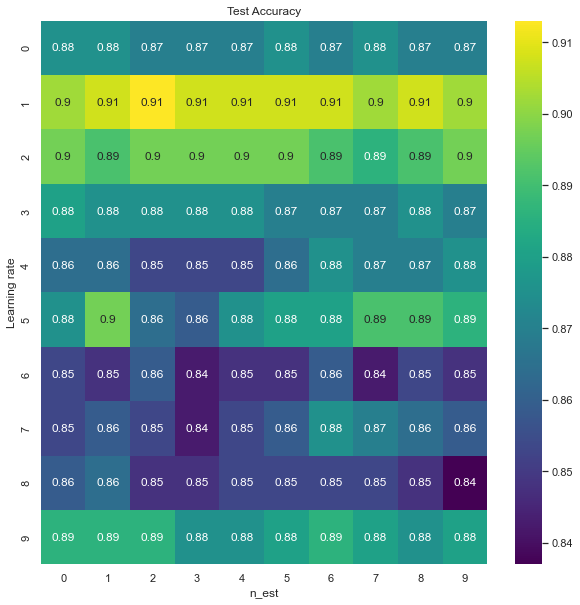

In [131]:
X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#No scaler
col_trans_none = make_column_transformer((oh,categorical),remainder='passthrough')

lr = np.linspace(0.1,1,10)
n_est = range(20, 30)
accuracy = np.zeros((len(lr), len(n_est)))
for n in range(len(lr)):
    for i in range(len(n_est)):
        model = GradientBoostingClassifier(n_estimators=n_est[i], learning_rate=lr[n], max_depth=4, min_samples_leaf=22, random_state=100)
        pipe = make_pipeline(col_trans_none, model)
        pipe.fit(X_train, y_train)
        y_pred_none = pipe.predict(X_test)
        accuracy[n][i] = round(accuracy_score(y_test, y_pred_none),4)

        
        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("Learning rate")
ax.set_xlabel("n_est")
plt.show()

In [132]:
accuracy

array([[0.875 , 0.875 , 0.8696, 0.8696, 0.8696, 0.875 , 0.8696, 0.875 ,
        0.8696, 0.8696],
       [0.9022, 0.9076, 0.913 , 0.9076, 0.9076, 0.9076, 0.9076, 0.9022,
        0.9076, 0.9022],
       [0.8967, 0.8913, 0.8967, 0.8967, 0.8967, 0.8967, 0.8913, 0.8859,
        0.8913, 0.8967],
       [0.8804, 0.875 , 0.875 , 0.875 , 0.875 , 0.8696, 0.8696, 0.8696,
        0.875 , 0.8696],
       [0.8641, 0.8641, 0.8533, 0.8533, 0.8533, 0.8641, 0.875 , 0.8696,
        0.8696, 0.875 ],
       [0.875 , 0.8967, 0.8641, 0.8587, 0.875 , 0.8804, 0.8804, 0.8913,
        0.8913, 0.8859],
       [0.8533, 0.8478, 0.8587, 0.8424, 0.8478, 0.8478, 0.8587, 0.8424,
        0.8533, 0.8478],
       [0.8533, 0.8587, 0.8533, 0.8424, 0.8533, 0.8587, 0.875 , 0.8696,
        0.8641, 0.8587],
       [0.8587, 0.8641, 0.8478, 0.8478, 0.8533, 0.8533, 0.8533, 0.8533,
        0.8478, 0.837 ],
       [0.8859, 0.8859, 0.8859, 0.875 , 0.875 , 0.8804, 0.8859, 0.8804,
        0.875 , 0.8804]])

### Testing accuracy with different tolerance for Gradient Boosting

Text(0, 0.5, 'Accuracy')

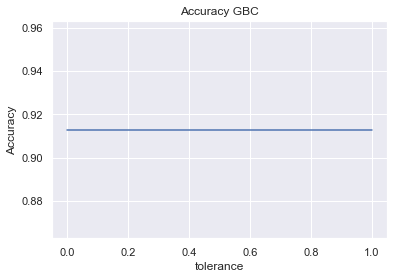

In [143]:
accuracy =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#No scaler
col_trans_none = make_column_transformer((oh,categorical),remainder='passthrough')

tol = np.logspace(-5,0,10)
for n in tol:
    model = GradientBoostingClassifier(n_estimators=22, learning_rate=0.2, max_depth=4, min_samples_leaf=22, tol = n, random_state=100)
    pipe = make_pipeline(col_trans_none, model)
    pipe.fit(X_train, y_train)
    y_pred_none = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred_none),4))

GBC_result_df = pd.DataFrame({'tolerance':tol, 'Accuracy':accuracy})
GBC_result_df   

plt.plot(tol, accuracy, label = "test_accuracy")
plt.xlabel('tolerance')
plt.title("Accuracy GBC")
plt.ylabel('Accuracy')

### Testing accuracy with different tolerance for Gradient Boosting

Text(0, 0.5, 'Accuracy')

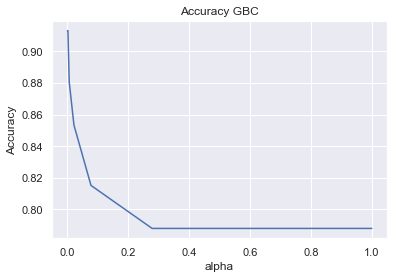

In [146]:


accuracy =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#No scaler
col_trans_none = make_column_transformer((oh,categorical),remainder='passthrough')

alpha = np.logspace(-6, -1, 10)
for n in alpha:
    model = GradientBoostingClassifier(n_estimators=22, learning_rate=0.2, max_depth=4, min_samples_leaf=22, ccp_alpha = n, random_state=100)
    pipe = make_pipeline(col_trans_none, model)
    pipe.fit(X_train, y_train)
    y_pred_none = pipe.predict(X_test)
    accuracy.append(round(accuracy_score(y_test, y_pred_none),4))

GBC_result_df = pd.DataFrame({'alpha':alpha, 'Accuracy':accuracy})
GBC_result_df   

plt.plot(tol, accuracy, label = "test_accuracy")
plt.xlabel('alpha')
plt.title("Accuracy GBC")
plt.ylabel('Accuracy')

## the final best performance of Gradient Boosting

In [130]:
accuracy =[]
scaler =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#No scaler
col_trans_none = make_column_transformer((oh,categorical),remainder='passthrough')  

model = GradientBoostingClassifier(learning_rate=0.2, n_estimators=22, max_depth=4, min_samples_leaf=22, random_state=100)
pipe = make_pipeline(col_trans_none, model)
pipe.fit(X_train, y_train)
y_pred_none = pipe.predict(X_test)
accuracy.append(round(pipe.score(X_train, y_train),4))
accuracy.append(round(accuracy_score(y_test, y_pred_none),4))


GBC_result_df = pd.DataFrame({'Accuracy':accuracy}, index=['Train_acc', 'Test_acc'])
GBC_result_df

,Accuracy
Train_acc,0.9183
Test_acc,0.9130


## Plot ROC for the best hyperparameter of Gradient Boosting

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\metrics\_ranking.py:998: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


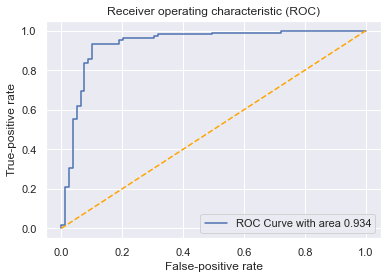

In [151]:
X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#No scaler
col_trans_none = make_column_transformer((oh,categorical),remainder='passthrough')

model = GradientBoostingClassifier(learning_rate=0.2, n_estimators=22, max_depth=4, min_samples_leaf=22, random_state=100)
pipe = make_pipeline(col_trans_none, model)
pipe.fit(X_train, y_train)

y_score =  pipe.decision_function(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=2) #get ROC curve


fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_score.ravel()) #Ravel y and score

roc_auccuracy = auc(fpr, tpr) #Getting area under ROC

#Plotting ROC:
plt.plot(fpr, tpr, label="ROC Curve with area %0.3f" % roc_auccuracy)
plt.plot([0, 1], [0, 1], color="orange", linestyle="--")
plt.legend(loc="lower right")
plt.xlabel("False-positive rate")
plt.ylabel("True-positive rate")
plt.title("Receiver operating characteristic (ROC)")
plt.show()

### Plot CG curve for the best hyperparameter of Gradient Boosting

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

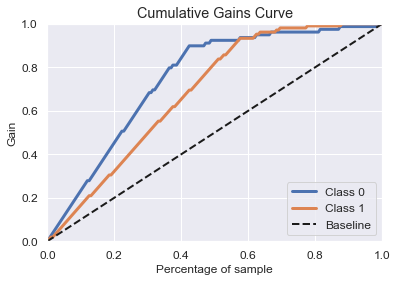

In [153]:
X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#No scaler
col_trans_none = make_column_transformer((oh,categorical),remainder='passthrough')

model = GradientBoostingClassifier(learning_rate=0.2, n_estimators=22, max_depth=4, min_samples_leaf=22, random_state=100)
pipe = make_pipeline(col_trans_none, model)
pipe.fit(X_train, y_train)

y_score =  pipe.predict_proba(X_test)

#dcg_score(y_test_oh, y_score)
skplt.metrics.plot_cumulative_gain(y_test, y_score)

### Plot confusion matrix for the best hyperparameter of Gradient Boosting

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

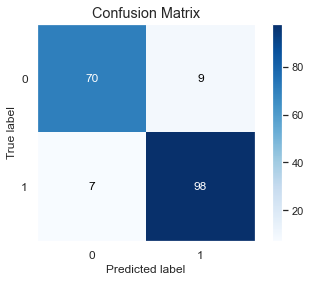

In [154]:
X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#No scaler
col_trans_none = make_column_transformer((oh,categorical),remainder='passthrough')

model = GradientBoostingClassifier(learning_rate=0.2, n_estimators=22, max_depth=4, min_samples_leaf=22, random_state=100)
pipe = make_pipeline(col_trans_none, model)
pipe.fit(X_train, y_train)
y_score =  pipe.predict(X_test)

#dcg_score(y_test_oh, y_score)
skplt.metrics.plot_confusion_matrix(y_test, y_score)

## Support Vector Machine from sklearn

### Support Vector Classifier with/without Scaler
We would only like to know the influence of Scaler, and did not change the rest hyperparameter of the model

In [7]:
accuracy =[]
scaler =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()

#No scaler
col_trans_none = make_column_transformer((oh,categorical),remainder='passthrough')  

model = SVC(random_state=100)
pipe = make_pipeline(col_trans_none, model)
pipe.fit(X_train, y_train)
y_pred_none = pipe.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred_none),4))
# print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

#using standard scaler
st = StandardScaler()
col_trans_st = make_column_transformer((oh,categorical),(st,numerical))  

model = SVC(random_state=100)
pipe = make_pipeline(col_trans_st, model)
pipe.fit(X_train, y_train)
y_pred_st = pipe.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred_st),4))

#using MinMax scaler
mm = MinMaxScaler()
col_trans_mm = make_column_transformer((oh,categorical),(mm,numerical))  

model = SVC(random_state=100)
pipe = make_pipeline(col_trans_mm, model)
pipe.fit(X_train, y_train)
y_pred_mm = pipe.predict(X_test)
accuracy.append(round(accuracy_score(y_test, y_pred_mm),4))

scaler = ['None', 'Standard', 'MinMax']
SVC_result_df = pd.DataFrame({'Accuracy':accuracy}, index=scaler)
SVC_result_df

,Accuracy
None,0.7065
Standard,0.8804
MinMax,0.8696


###  Tesing SVM with different scaler of differ-ent degrees and their corresponding accuracy

In [162]:

degree = [1, 2, 3, 4, 5, 6, 7, 8]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()

#No scaler
col_trans_none = make_column_transformer((oh,categorical),remainder='passthrough')  

none_acc = []

for i in degree:
    model = SVC(degree = i, kernel = 'poly', random_state=100)
    pipe = make_pipeline(col_trans_none, model)
    pipe.fit(X_train, y_train)
    y_pred_none = pipe.predict(X_test)
    none_acc.append(round(accuracy_score(y_test, y_pred_none),4))


#using standard scaler
st = StandardScaler()
col_trans_st = make_column_transformer((oh,categorical),(st,numerical))  

st_acc = []

for i in degree:
    model = SVC(degree = i, kernel = 'poly',random_state=100)
    pipe = make_pipeline(col_trans_st, model)
    pipe.fit(X_train, y_train)
    y_pred_st = pipe.predict(X_test)
    st_acc.append(round(accuracy_score(y_test, y_pred_st),4))

#using MinMax scaler
mm = MinMaxScaler()
col_trans_mm = make_column_transformer((oh,categorical),(mm,numerical))  

mm_acc = []

for i in degree:
    model = SVC(degree = i, kernel = 'poly',random_state=100)
    pipe = make_pipeline(col_trans_mm, model)
    pipe.fit(X_train, y_train)
    y_pred_mm = pipe.predict(X_test)
    mm_acc.append(round(accuracy_score(y_test, y_pred_mm),4))


SVC_result_df = pd.DataFrame({'No scaler':none_acc, 'Standard scaler':st_acc, 'MinMax scaler':mm_acc}, index=degree)
SVC_result_df

,No scaler,Standard scaler,MinMax scaler
1,0.6739,0.8750,0.8859
2,0.6902,0.8750,0.8750
3,0.6902,0.8804,0.8750
4,0.7283,0.8750,0.8587
5,0.7120,0.8478,0.8478
6,0.7283,0.8370,0.8152
7,0.7174,0.8098,0.8043
8,0.7174,0.7663,0.8098


###  Tesing SVM with different kernel
The previous testing has proved that the standard scaler has the best performance the MinMax scaler and no scaler. Therefore, we will only use standard scaler for rest testing

In [193]:
accuracy_st =[]
accuracy_mm =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#using MinMax scaler
mm = MinMaxScaler()
col_trans_mm = make_column_transformer((oh,categorical),(mm,numerical)) 

kr = ['linear', 'poly', 'rbf', 'sigmoid']

for i in kr:
    model = SVC(kernel = i,random_state=100)
    pipe = make_pipeline(col_trans_mm, model)
    pipe.fit(X_train, y_train)
    y_pred_mm = pipe.predict(X_test)
    accuracy_mm.append(round(accuracy_score(y_test, y_pred_mm),4))

#using standard scaler
st = StandardScaler()
col_trans_mm = make_column_transformer((oh,categorical),(st,numerical)) 

kr = ['linear', 'poly', 'rbf', 'sigmoid']

for i in kr:
    model = SVC(kernel = i,random_state=100)
    pipe = make_pipeline(col_trans_st, model)
    pipe.fit(X_train, y_train)
    y_pred_st = pipe.predict(X_test)
    accuracy_st.append(round(accuracy_score(y_test, y_pred_st),4))    
    
SVC_result_df = pd.DataFrame({'Standard Scaler':accuracy_st, 'MinMax Scaler': accuracy_mm}, index=kr)
SVC_result_df

,Standard Scaler,MinMax Scaler
linear,0.8804,0.8750
poly,0.8804,0.8750
rbf,0.8804,0.8696
sigmoid,0.7717,0.7554


It shows that the kernel of linear, poly and rbf have same performance.

### Tesing SVM with different Regularization parameter

Text(0, 0.5, 'Accuracy')

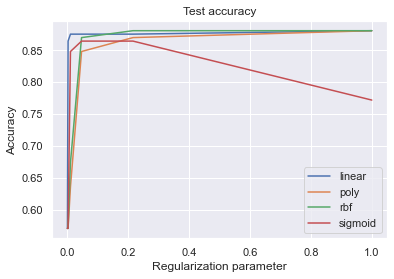

In [168]:
accuracy =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#using standard scaler
st = StandardScaler()
col_trans_st = make_column_transformer((oh,categorical),(st,numerical)) 

kr = ['linear', 'poly', 'rbf', 'sigmoid']
regulariztion = np.logspace(-6, 0, 10)

for i in kr:
    acc = []
    for c in regulariztion:
        model = SVC(kernel = i,C=c, random_state=100)
        pipe = make_pipeline(col_trans_st, model)
        pipe.fit(X_train, y_train)
        y_pred_st = pipe.predict(X_test)
        acc.append(round(accuracy_score(y_test, y_pred_st),4))
        
    accuracy.append(acc)

plt.plot(regulariztion , accuracy[0], label = "linear")
plt.plot(regulariztion , accuracy[1], label = "poly")
plt.plot(regulariztion , accuracy[2], label = "rbf")
plt.plot(regulariztion , accuracy[3], label = "sigmoid")
plt.legend(["linear", "poly", "rbf", "sigmoid"])
plt.title("Test accuracy")
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')    
    
#SVC_result_df = pd.DataFrame({'Accuracy':accuracy}, index=kr)
#SVC_result_df

### Tesing SVM with different tolerance

Text(0, 0.5, 'Accuracy')

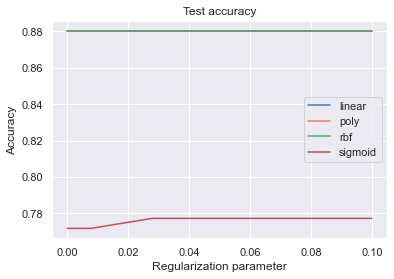

In [173]:
accuracy =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#using standard scaler
st = StandardScaler()
col_trans_st = make_column_transformer((oh,categorical),(st,numerical))

tolerance = np.logspace(-6, -1, 10)
kr = ['linear', 'poly', 'rbf', 'sigmoid']

for i in kr:
    acc = []
    for n in tolerance:
        model = SVC(kernel = i,tol=n, random_state=100)
        pipe = make_pipeline(col_trans_st, model)
        pipe.fit(X_train, y_train)
        y_pred_st = pipe.predict(X_test)
        acc.append(round(accuracy_score(y_test, y_pred_st),4))
    accuracy.append(acc)

#SVC_result_df = pd.DataFrame({'alpha':alpha, 'Accuracy':accuracy})
#SVC_result_df   

plt.plot(tolerance , accuracy[0], label = "linear")
plt.plot(tolerance , accuracy[1], label = "poly")
plt.plot(tolerance , accuracy[2], label = "rbf")
plt.plot(tolerance , accuracy[3], label = "sigmoid")
plt.legend(["linear", "poly", "rbf", "sigmoid"])
plt.title("Test accuracy")
plt.xlabel('Regularization parameter')
plt.ylabel('Accuracy')

### Tesing SVM with different max_iter

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=201).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=202).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=203).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWar

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=238).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=239).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=240).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=241).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWar

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=283).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=284).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=285).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=286).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWar

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=225).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=226).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=227).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=228).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWar

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=271).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=272).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=273).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=274).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWar

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=211).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=212).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=213).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=214).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWar

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=248).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=249).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=251).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWar

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=291).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=292).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=293).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=294).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWar

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=233).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=234).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=235).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=236).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWar

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=274).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=275).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=276).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=277).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWar

Text(0, 0.5, 'Accuracy')

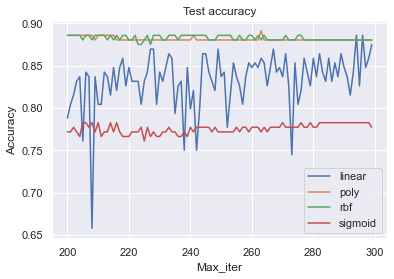

In [188]:
accuracy =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#using standard scaler
st = StandardScaler()
col_trans_st = make_column_transformer((oh,categorical),(st,numerical))

max_iter = 300
kr = ['linear', 'poly', 'rbf', 'sigmoid']

for i in kr:
    acc = []
    for n in range(200, max_iter):
        model = SVC(kernel = i,max_iter=n, random_state=100)
        pipe = make_pipeline(col_trans_st, model)
        pipe.fit(X_train, y_train)
        y_pred_st = pipe.predict(X_test)
        acc.append(round(accuracy_score(y_test, y_pred_st),4))
    accuracy.append(acc)
         
plt.plot(range(200, max_iter) , accuracy[0], label = "linear")
plt.plot(range(200, max_iter) , accuracy[1], label = "poly")
plt.plot(range(200, max_iter) , accuracy[2], label = "rbf")
plt.plot(range(200, max_iter) , accuracy[3], label = "sigmoid")
plt.legend(["linear", "poly", "rbf", "sigmoid"])
plt.title("Test accuracy")
plt.xlabel('Max_iter')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

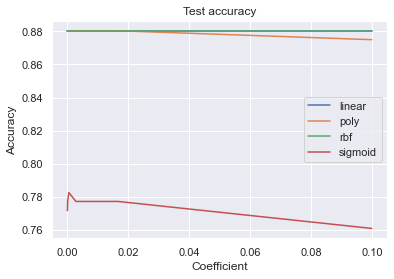

In [190]:
accuracy =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#using standard scaler
st = StandardScaler()
col_trans_st = make_column_transformer((oh,categorical),(st,numerical))

coef = np.logspace(-8, -1, 10)
kr = ['linear', 'poly', 'rbf', 'sigmoid']

for i in kr:
    acc = []
    for n in coef:
        model = SVC(kernel = i,coef0=n, random_state=100)
        pipe = make_pipeline(col_trans_st, model)
        pipe.fit(X_train, y_train)
        y_pred_st = pipe.predict(X_test)
        acc.append(round(accuracy_score(y_test, y_pred_st),4))
    accuracy.append(acc)
         
plt.plot(coef , accuracy[0], label = "linear")
plt.plot(coef , accuracy[1], label = "poly")
plt.plot(coef , accuracy[2], label = "rbf")
plt.plot(coef , accuracy[3], label = "sigmoid")
plt.legend(["linear", "poly", "rbf", "sigmoid"])
plt.title("Test accuracy")
plt.xlabel('Coefficient')
plt.ylabel('Accuracy')

## The final best performance of SVC

In [8]:
accuracy =[]

X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#using MinMax scaler
mm = MinMaxScaler()
col_trans_mm = make_column_transformer((oh,categorical),(mm,numerical))  

model = SVC(degree = 1, kernel = 'poly', random_state=100)
pipe = make_pipeline(col_trans_mm, model)
pipe.fit(X_train, y_train)
y_pred_mm = pipe.predict(X_test)

accuracy.append(round(pipe.score(X_train, y_train),4))
accuracy.append(round(accuracy_score(y_test, y_pred_mm),4))

SVC_result_df = pd.DataFrame({'Accuracy':accuracy}, index=['Train_acc', 'Test_acc'])
SVC_result_df

,Accuracy
Train_acc,0.8692
Test_acc,0.8859


### Plot ROC for the best hyperparameter of SVC

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\metrics\_ranking.py:998: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


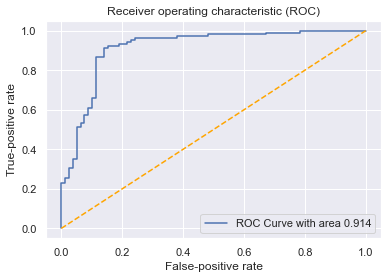

In [63]:
X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#using MinMax scaler
mm = MinMaxScaler()
col_trans_mm = make_column_transformer((oh,categorical),(mm,numerical))  

model = SVC(degree = 1, kernel = 'poly', random_state=100)
pipe = make_pipeline(col_trans_mm, model)
pipe.fit(X_train, y_train)

y_score =  pipe.decision_function(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=2) #get ROC curve


fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_score.ravel()) #Ravel y and score

roc_auccuracy = auc(fpr, tpr) #Getting area under ROC

#Plotting ROC:
plt.plot(fpr, tpr, label="ROC Curve with area %0.3f" % roc_auccuracy)
plt.plot([0, 1], [0, 1], color="orange", linestyle="--")
plt.legend(loc="lower right")
plt.xlabel("False-positive rate")
plt.ylabel("True-positive rate")
plt.title("Receiver operating characteristic (ROC)")
plt.show()

### Plot CG curve for the best hyperparameter of SVC

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

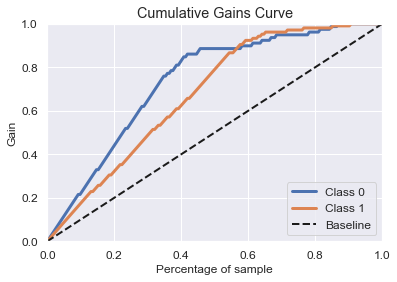

In [65]:
X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#using MinMax scaler
mm = MinMaxScaler()
col_trans_mm = make_column_transformer((oh,categorical),(mm,numerical))  

model = SVC(degree = 1, kernel = 'poly',probability=True, random_state=100)
pipe = make_pipeline(col_trans_mm, model)
pipe.fit(X_train, y_train)

y_score =  pipe.predict_proba(X_test)

#dcg_score(y_test_oh, y_score)
skplt.metrics.plot_cumulative_gain(y_test, y_score)

### Plot confusion matrix for the best hyperparameter of SVC

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

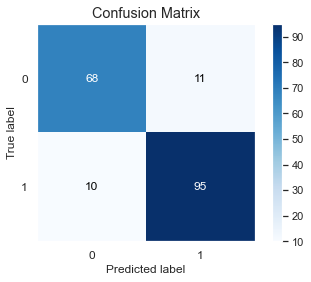

In [66]:
X= df.drop('HeartDisease', axis=1)
y= df['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

oh= OneHotEncoder()
#using MinMax scaler
mm = MinMaxScaler()
col_trans_mm = make_column_transformer((oh,categorical),(mm,numerical))  

model = SVC(degree = 1, kernel = 'poly', random_state=100)
pipe = make_pipeline(col_trans_mm, model)
pipe.fit(X_train, y_train)
y_score =  pipe.predict(X_test)

#dcg_score(y_test_oh, y_score)
skplt.metrics.plot_confusion_matrix(y_test, y_score)

## Neural Network

In [70]:
epochs = 100
batch_size = 100
n_neurons_layer1 = 100
n_neurons_layer2 = 50
n_categories = 2
eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)
def create_neural_network_keras(n_neurons_layer1, n_neurons_layer2, n_categories, eta, lmbd):
    model = Sequential()
    model.add(Dense(n_neurons_layer1, activation='sigmoid', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dense(n_neurons_layer2, activation='sigmoid', kernel_regularizer=regularizers.l2(lmbd)))
    model.add(Dense(n_categories, activation='softmax'))
    
    sgd = optimizers.SGD(lr=eta)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model

In [36]:
#prepare the dataset
X_categorical = df[categorical]
X_numerical = df[numerical]
X_categorical_oh = pd.get_dummies(X_categorical) #Getting dummy matrix of X

#using MinMax scaler
mm = MinMaxScaler()
X_numerical_mm = mm.fit_transform(X_numerical)
X_numerical_mm = pd.DataFrame(X_numerical_mm, columns = X_numerical.columns)

X_mm = pd.concat([X_categorical_oh, X_numerical_mm], axis=1)


#using MinMax scaler
st = StandardScaler()
X_numerical_st = st.fit_transform(X_numerical)
X_numerical_st = pd.DataFrame(X_numerical_st, columns = X_numerical.columns)

X_st = pd.concat([X_categorical_oh, X_numerical_st], axis=1)

#No Scaler
X_none = pd.concat([X_categorical_oh, X_numerical], axis=1)


In [50]:
y_label = to_categorical(y)
y_label.shape

(918, 2)

In [51]:
#Split dataset 
X_train_none, X_test_none, y_train_none, y_test_none = train_test_split(X_none, y_label, test_size=0.2, random_state=100)
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(X_st, y_label, test_size=0.2, random_state=100)
X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X_mm, y_label, test_size=0.2, random_state=100)


### DNN from keras without scaler

In [56]:


DNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        DNN = create_neural_network_keras(n_neurons_layer1, n_neurons_layer2, n_categories,
                                         eta=eta, lmbd=lmbd)
        
        DNN.fit(X_train_none, y_train_none, epochs=epochs, batch_size=batch_size, verbose=0)
        scores = DNN.evaluate(X_test_none, y_test_none)
        
        DNN_keras[i][j] = DNN
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % scores[1])
        print()

C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.9885 - accuracy: 0.5707
Learning rate =  1e-05
Lambda =  1e-05
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.7113 - accuracy: 0.4402
Learning rate =  1e-05
Lambda =  0.0001
Test accuracy: 0.440



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.8596 - accuracy: 0.5707
Learning rate =  1e-05
Lambda =  0.001
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 1.9004 - accuracy: 0.4293
Learning rate =  1e-05
Lambda =  0.01
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 10.7389 - accuracy: 0.4620
Learning rate =  1e-05
Lambda =  0.1
Test accuracy: 0.462



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 96.8034 - accuracy: 0.4293
Learning rate =  1e-05
Lambda =  1.0
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 728.6365 - accuracy: 0.5707
Learning rate =  1e-05
Lambda =  10.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.6865 - accuracy: 0.5652
Learning rate =  0.0001
Lambda =  1e-05
Test accuracy: 0.565



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.6860 - accuracy: 0.5543
Learning rate =  0.0001
Lambda =  0.0001
Test accuracy: 0.554



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.7854 - accuracy: 0.5707
Learning rate =  0.0001
Lambda =  0.001
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 1.6830 - accuracy: 0.5707
Learning rate =  0.0001
Lambda =  0.01
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 10.3324 - accuracy: 0.6902
Learning rate =  0.0001
Lambda =  0.1
Test accuracy: 0.690



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 72.7685 - accuracy: 0.5707
Learning rate =  0.0001
Lambda =  1.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 40.8885 - accuracy: 0.4293
Learning rate =  0.0001
Lambda =  10.0
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.6499 - accuracy: 0.6848
Learning rate =  0.001
Lambda =  1e-05
Test accuracy: 0.685



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.6463 - accuracy: 0.7011
Learning rate =  0.001
Lambda =  0.0001
Test accuracy: 0.701



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.7531 - accuracy: 0.6848
Learning rate =  0.001
Lambda =  0.001
Test accuracy: 0.685



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 1.6340 - accuracy: 0.6957
Learning rate =  0.001
Lambda =  0.01
Test accuracy: 0.696



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 7.8404 - accuracy: 0.6902
Learning rate =  0.001
Lambda =  0.1
Test accuracy: 0.690



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 4.7622 - accuracy: 0.5707
Learning rate =  0.001
Lambda =  1.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.5707
Learning rate =  0.001
Lambda =  10.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.5954 - accuracy: 0.7011
Learning rate =  0.01
Lambda =  1e-05
Test accuracy: 0.701



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 1s 1ms/step - loss: 0.6004 - accuracy: 0.7065
Learning rate =  0.01
Lambda =  0.0001
Test accuracy: 0.707



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 1s 3ms/step - loss: 0.6800 - accuracy: 0.7120
Learning rate =  0.01
Lambda =  0.001
Test accuracy: 0.712



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 1.3331 - accuracy: 0.6957
Learning rate =  0.01
Lambda =  0.01
Test accuracy: 0.696



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 1.0532 - accuracy: 0.6576
Learning rate =  0.01
Lambda =  0.1
Test accuracy: 0.658



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.6851 - accuracy: 0.5707
Learning rate =  0.01
Lambda =  1.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.6838 - accuracy: 0.5707
Learning rate =  0.01
Lambda =  10.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.6199 - accuracy: 0.6141
Learning rate =  0.1
Lambda =  1e-05
Test accuracy: 0.614



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.6106 - accuracy: 0.6848
Learning rate =  0.1
Lambda =  0.0001
Test accuracy: 0.685



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.6952 - accuracy: 0.6413
Learning rate =  0.1
Lambda =  0.001
Test accuracy: 0.641



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.8558 - accuracy: 0.5543
Learning rate =  0.1
Lambda =  0.01
Test accuracy: 0.554



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.7058 - accuracy: 0.5707
Learning rate =  0.1
Lambda =  0.1
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.6837 - accuracy: 0.5707
Learning rate =  0.1
Lambda =  1.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 1042.9458 - accuracy: 0.6033
Learning rate =  0.1
Lambda =  10.0
Test accuracy: 0.603



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 997us/step - loss: 0.6466 - accuracy: 0.5707
Learning rate =  1.0
Lambda =  1e-05
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.6532 - accuracy: 0.5598
Learning rate =  1.0
Lambda =  0.0001
Test accuracy: 0.560



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.6659 - accuracy: 0.5543
Learning rate =  1.0
Lambda =  0.001
Test accuracy: 0.554



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.7283 - accuracy: 0.5707
Learning rate =  1.0
Lambda =  0.01
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.5707
Learning rate =  1.0
Lambda =  0.1
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 419.7406 - accuracy: 0.4293
Learning rate =  1.0
Lambda =  1.0
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.4293
Learning rate =  1.0
Lambda =  10.0
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 2.9655 - accuracy: 0.4293
Learning rate =  10.0
Lambda =  1e-05
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 1.6059 - accuracy: 0.5707
Learning rate =  10.0
Lambda =  0.0001
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.7563 - accuracy: 0.4293
Learning rate =  10.0
Lambda =  0.001
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 1.4658 - accuracy: 0.4293
Learning rate =  10.0
Lambda =  0.01
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 4850.5117 - accuracy: 0.5707
Learning rate =  10.0
Lambda =  0.1
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.4293
Learning rate =  10.0
Lambda =  1.0
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.4293
Learning rate =  10.0
Lambda =  10.0
Test accuracy: 0.429



6/6 [==============================] - 0s 2ms/step - loss: 4850.5117 - accuracy: 0.5707


6/6 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.4293


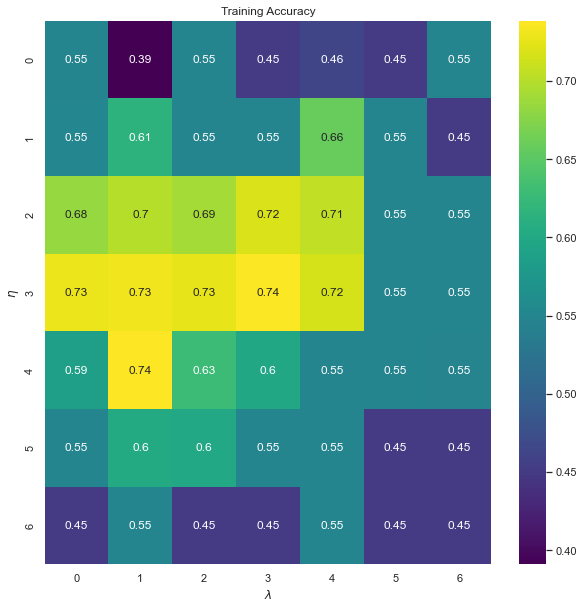

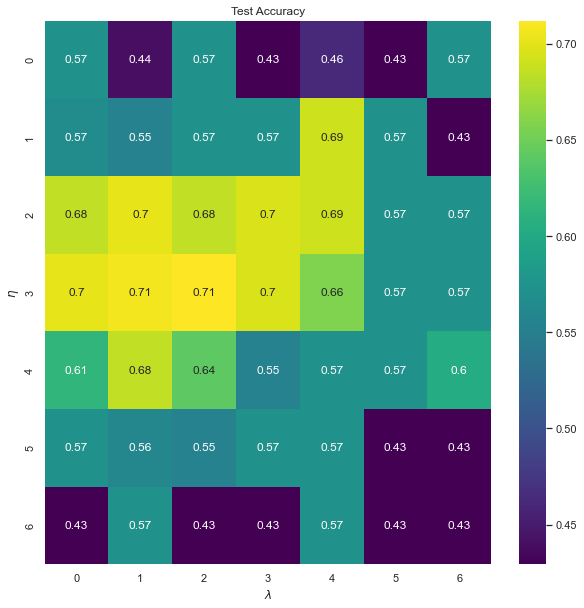

In [58]:

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        DNN = DNN_keras[i][j]

        train_accuracy[i][j] = DNN.evaluate(X_train_none, y_train_none)[1]
        test_accuracy[i][j] = DNN.evaluate(X_test_none, y_test_none)[1]

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

### DNN from keras with Standard scaler

In [59]:
DNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        DNN = create_neural_network_keras(n_neurons_layer1, n_neurons_layer2, n_categories,
                                         eta=eta, lmbd=lmbd)
        
        DNN.fit(X_train_st, y_train_st, epochs=epochs, batch_size=batch_size, verbose=0)
        scores = DNN.evaluate(X_test_st, y_test_st)
        
        DNN_keras[i][j] = DNN
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % scores[1])
        print()

C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.8096 - accuracy: 0.5707
Learning rate =  1e-05
Lambda =  1e-05
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.7889 - accuracy: 0.4293
Learning rate =  1e-05
Lambda =  0.0001
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.7851 - accuracy: 0.5707
Learning rate =  1e-05
Lambda =  0.001
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 1.6974 - accuracy: 0.5707
Learning rate =  1e-05
Lambda =  0.01
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 10.7872 - accuracy: 0.5707
Learning rate =  1e-05
Lambda =  0.1
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 97.0768 - accuracy: 0.5707
Learning rate =  1e-05
Lambda =  1.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 728.5038 - accuracy: 0.5707
Learning rate =  1e-05
Lambda =  10.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.8035 - accuracy: 0.4293
Learning rate =  0.0001
Lambda =  1e-05
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.7613 - accuracy: 0.5707
Learning rate =  0.0001
Lambda =  0.0001
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.7941 - accuracy: 0.5707
Learning rate =  0.0001
Lambda =  0.001
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 1.6924 - accuracy: 0.5707
Learning rate =  0.0001
Lambda =  0.01
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 9.9972 - accuracy: 0.4293
Learning rate =  0.0001
Lambda =  0.1
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 72.6227 - accuracy: 0.4293
Learning rate =  0.0001
Lambda =  1.0
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 41.7046 - accuracy: 0.4293
Learning rate =  0.0001
Lambda =  10.0
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 995us/step - loss: 0.6769 - accuracy: 0.5707
Learning rate =  0.001
Lambda =  1e-05
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.7013 - accuracy: 0.5707
Learning rate =  0.001
Lambda =  0.0001
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.7738 - accuracy: 0.5707
Learning rate =  0.001
Lambda =  0.001
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 1.6132 - accuracy: 0.5707
Learning rate =  0.001
Lambda =  0.01
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 7.7707 - accuracy: 0.5707
Learning rate =  0.001
Lambda =  0.1
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 4.6884 - accuracy: 0.5707
Learning rate =  0.001
Lambda =  1.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 998us/step - loss: 0.6841 - accuracy: 0.5707
Learning rate =  0.001
Lambda =  10.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.5988 - accuracy: 0.7609
Learning rate =  0.01
Lambda =  1e-05
Test accuracy: 0.761



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.6048 - accuracy: 0.8261
Learning rate =  0.01
Lambda =  0.0001
Test accuracy: 0.826



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 4ms/step - loss: 0.7006 - accuracy: 0.8043
Learning rate =  0.01
Lambda =  0.001
Test accuracy: 0.804



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 1.3668 - accuracy: 0.7772
Learning rate =  0.01
Lambda =  0.01
Test accuracy: 0.777



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 1.0902 - accuracy: 0.5707
Learning rate =  0.01
Lambda =  0.1
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.6836 - accuracy: 0.5707
Learning rate =  0.01
Lambda =  1.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.6841 - accuracy: 0.5707
Learning rate =  0.01
Lambda =  10.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.3581 - accuracy: 0.8750
Learning rate =  0.1
Lambda =  1e-05
Test accuracy: 0.875



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.3639 - accuracy: 0.8804
Learning rate =  0.1
Lambda =  0.0001
Test accuracy: 0.880



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.4314 - accuracy: 0.8804
Learning rate =  0.1
Lambda =  0.001
Test accuracy: 0.880



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.5486 - accuracy: 0.8315
Learning rate =  0.1
Lambda =  0.01
Test accuracy: 0.832



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.6835 - accuracy: 0.5707
Learning rate =  0.1
Lambda =  0.1
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 7ms/step - loss: 0.6836 - accuracy: 0.5707
Learning rate =  0.1
Lambda =  1.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 1010.9737 - accuracy: 0.4293
Learning rate =  0.1
Lambda =  10.0
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.3476 - accuracy: 0.8913
Learning rate =  1.0
Lambda =  1e-05
Test accuracy: 0.891



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.3639 - accuracy: 0.8804
Learning rate =  1.0
Lambda =  0.0001
Test accuracy: 0.880



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.4113 - accuracy: 0.8533
Learning rate =  1.0
Lambda =  0.001
Test accuracy: 0.853



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.7671 - accuracy: 0.6685
Learning rate =  1.0
Lambda =  0.01
Test accuracy: 0.668



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.7375 - accuracy: 0.5707
Learning rate =  1.0
Lambda =  0.1
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 278.5634 - accuracy: 0.4293
Learning rate =  1.0
Lambda =  1.0
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.4293
Learning rate =  1.0
Lambda =  10.0
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.7425 - accuracy: 0.8696
Learning rate =  10.0
Lambda =  1e-05
Test accuracy: 0.870



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.7219 - accuracy: 0.7554
Learning rate =  10.0
Lambda =  0.0001
Test accuracy: 0.755



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 997us/step - loss: 0.5987 - accuracy: 0.8587
Learning rate =  10.0
Lambda =  0.001
Test accuracy: 0.859



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 4ms/step - loss: 0.7069 - accuracy: 0.5707
Learning rate =  10.0
Lambda =  0.01
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 281.3802 - accuracy: 0.5707
Learning rate =  10.0
Lambda =  0.1
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.4293
Learning rate =  10.0
Lambda =  1.0
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.4293
Learning rate =  10.0
Lambda =  10.0
Test accuracy: 0.429



6/6 [==============================] - 0s 3ms/step - loss: 281.3802 - accuracy: 0.5707


6/6 [==============================] - 0s 997us/step - loss: nan - accuracy: 0.4293


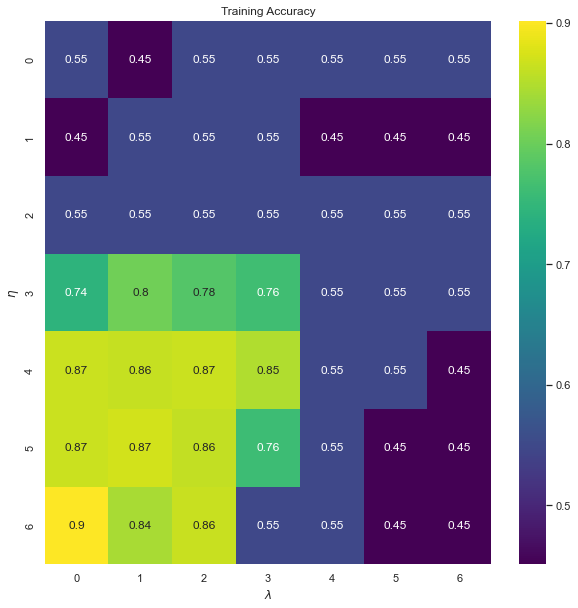

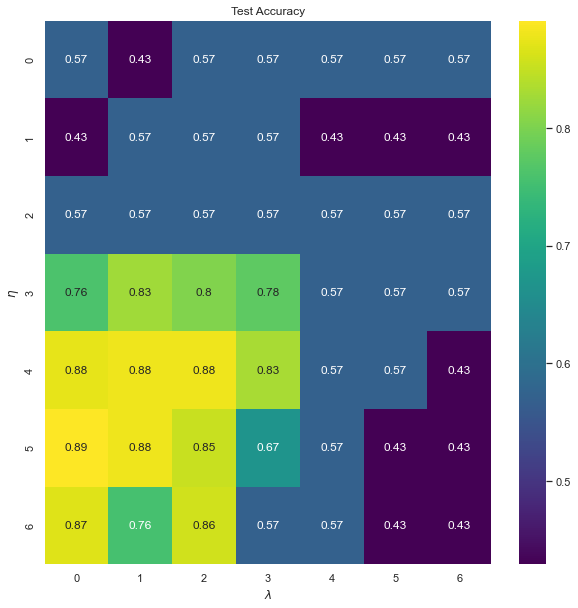

In [60]:
sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        DNN = DNN_keras[i][j]

        train_accuracy[i][j] = DNN.evaluate(X_train_st, y_train_st)[1]
        test_accuracy[i][j] = DNN.evaluate(X_test_st, y_test_st)[1]

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

### DNN from keras with MinMax scaler

In [61]:
DNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        DNN = create_neural_network_keras(n_neurons_layer1, n_neurons_layer2, n_categories,
                                         eta=eta, lmbd=lmbd)
        
        DNN.fit(X_train_mm, y_train_mm, epochs=epochs, batch_size=batch_size, verbose=0)
        scores = DNN.evaluate(X_test_mm, y_test_mm)
        
        DNN_keras[i][j] = DNN
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % scores[1])
        print()

C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.6921 - accuracy: 0.4620
Learning rate =  1e-05
Lambda =  1e-05
Test accuracy: 0.462



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 997us/step - loss: 1.0431 - accuracy: 0.5707
Learning rate =  1e-05
Lambda =  0.0001
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.9230 - accuracy: 0.4293
Learning rate =  1e-05
Lambda =  0.001
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 1.9302 - accuracy: 0.5707
Learning rate =  1e-05
Lambda =  0.01
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 11.1320 - accuracy: 0.4293
Learning rate =  1e-05
Lambda =  0.1
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 98.6687 - accuracy: 0.5707
Learning rate =  1e-05
Lambda =  1.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 716.1188 - accuracy: 0.4293
Learning rate =  1e-05
Lambda =  10.0
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.6767 - accuracy: 0.5707
Learning rate =  0.0001
Lambda =  1e-05
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.7407 - accuracy: 0.4293
Learning rate =  0.0001
Lambda =  0.0001
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.8145 - accuracy: 0.4293
Learning rate =  0.0001
Lambda =  0.001
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 1.7243 - accuracy: 0.4293
Learning rate =  0.0001
Lambda =  0.01
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 10.3532 - accuracy: 0.5707
Learning rate =  0.0001
Lambda =  0.1
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 74.3519 - accuracy: 0.5707
Learning rate =  0.0001
Lambda =  1.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 41.7502 - accuracy: 0.4293
Learning rate =  0.0001
Lambda =  10.0
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.6856 - accuracy: 0.5707
Learning rate =  0.001
Lambda =  1e-05
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.6873 - accuracy: 0.5707
Learning rate =  0.001
Lambda =  0.0001
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.7846 - accuracy: 0.5707
Learning rate =  0.001
Lambda =  0.001
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 1.6681 - accuracy: 0.5707
Learning rate =  0.001
Lambda =  0.01
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 7.8897 - accuracy: 0.5707
Learning rate =  0.001
Lambda =  0.1
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 4.7965 - accuracy: 0.5707
Learning rate =  0.001
Lambda =  1.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.6839 - accuracy: 0.5707
Learning rate =  0.001
Lambda =  10.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.6592 - accuracy: 0.5707
Learning rate =  0.01
Lambda =  1e-05
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.6465 - accuracy: 0.7391
Learning rate =  0.01
Lambda =  0.0001
Test accuracy: 0.739



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.7490 - accuracy: 0.5707
Learning rate =  0.01
Lambda =  0.001
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 2s 2ms/step - loss: 1.3996 - accuracy: 0.5707
Learning rate =  0.01
Lambda =  0.01
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 1.0896 - accuracy: 0.5707
Learning rate =  0.01
Lambda =  0.1
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.6840 - accuracy: 0.5707
Learning rate =  0.01
Lambda =  1.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.6855 - accuracy: 0.5707
Learning rate =  0.01
Lambda =  10.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.3898 - accuracy: 0.8315
Learning rate =  0.1
Lambda =  1e-05
Test accuracy: 0.832



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.3677 - accuracy: 0.8750
Learning rate =  0.1
Lambda =  0.0001
Test accuracy: 0.875



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.4505 - accuracy: 0.8804
Learning rate =  0.1
Lambda =  0.001
Test accuracy: 0.880



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.5282 - accuracy: 0.8750
Learning rate =  0.1
Lambda =  0.01
Test accuracy: 0.875



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.6963 - accuracy: 0.5707
Learning rate =  0.1
Lambda =  0.1
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.4293
Learning rate =  0.1
Lambda =  1.0
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 1014.2469 - accuracy: 0.5707
Learning rate =  0.1
Lambda =  10.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.3651 - accuracy: 0.8641
Learning rate =  1.0
Lambda =  1e-05
Test accuracy: 0.864



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.4202 - accuracy: 0.8261
Learning rate =  1.0
Lambda =  0.0001
Test accuracy: 0.826



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.4034 - accuracy: 0.8750
Learning rate =  1.0
Lambda =  0.001
Test accuracy: 0.875



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 0.9792 - accuracy: 0.5707
Learning rate =  1.0
Lambda =  0.01
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 5ms/step - loss: 0.7553 - accuracy: 0.5707
Learning rate =  1.0
Lambda =  0.1
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 311.5096 - accuracy: 0.5707
Learning rate =  1.0
Lambda =  1.0
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.4293
Learning rate =  1.0
Lambda =  10.0
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 4.8267 - accuracy: 0.5707
Learning rate =  10.0
Lambda =  1e-05
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: 0.5391 - accuracy: 0.8696
Learning rate =  10.0
Lambda =  0.0001
Test accuracy: 0.870



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 2.8233 - accuracy: 0.5707
Learning rate =  10.0
Lambda =  0.001
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 2.8444 - accuracy: 0.5707
Learning rate =  10.0
Lambda =  0.01
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 2ms/step - loss: 1335.9481 - accuracy: 0.5707
Learning rate =  10.0
Lambda =  0.1
Test accuracy: 0.571



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.4293
Learning rate =  10.0
Lambda =  1.0
Test accuracy: 0.429



C:\Users\bod\AppData\Roaming\Python\Python39\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6/6 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.4293
Learning rate =  10.0
Lambda =  10.0
Test accuracy: 0.429



6/6 [==============================] - 0s 1ms/step - loss: 1335.9481 - accuracy: 0.5707


6/6 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.4293


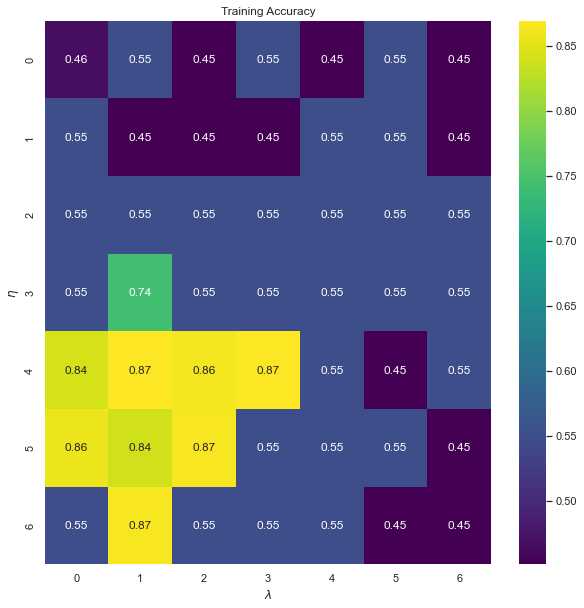

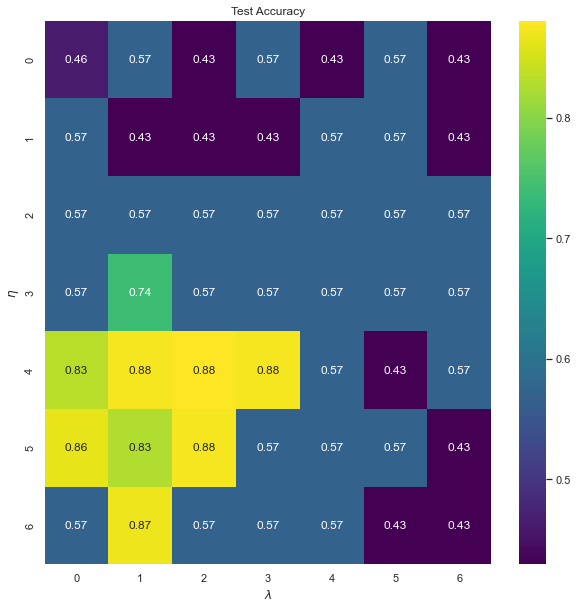

In [62]:
sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        DNN = DNN_keras[i][j]

        train_accuracy[i][j] = DNN.evaluate(X_train_mm, y_train_mm)[1]
        test_accuracy[i][j] = DNN.evaluate(X_test_mm, y_test_mm)[1]

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

## Our own neural network  

In [72]:
lr = np.logspace(-5, 1, 7)
lmbd = np.logspace(-5, 1, 7)

C:\Users\bod\AppData\Local\Temp/ipykernel_2336/148217150.py:239: RuntimeWarning: divide by zero encountered in true_divide
  self.grad_input = (-y_real/d_val)/sample
C:\Users\bod\AppData\Local\Temp/ipykernel_2336/148217150.py:239: RuntimeWarning: invalid value encountered in true_divide
  self.grad_input = (-y_real/d_val)/sample
C:\Users\bod\AppData\Local\Temp/ipykernel_2336/148217150.py:239: RuntimeWarning: overflow encountered in true_divide
  self.grad_input = (-y_real/d_val)/sample


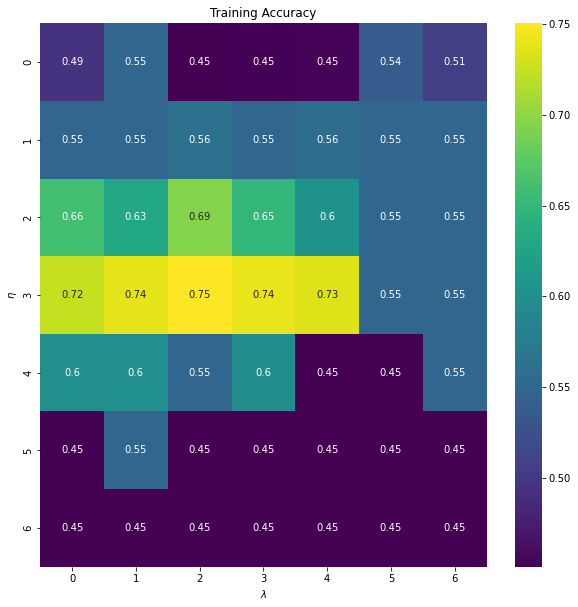

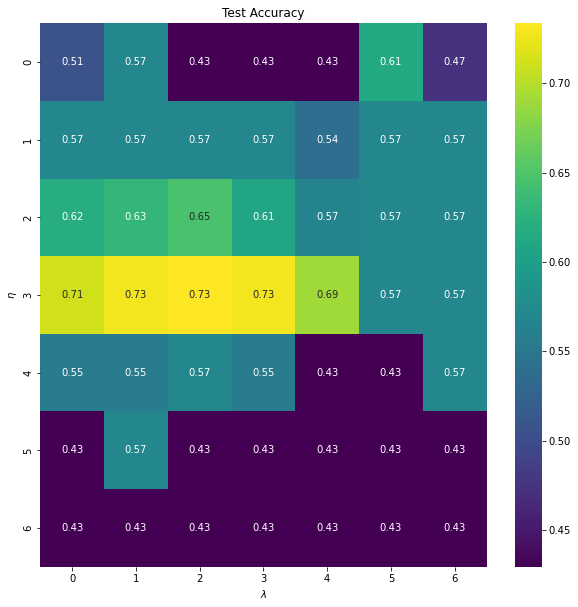

In [43]:
train_accuracy = np.zeros((len(lr), len(lmbd)))
test_accuracy = np.zeros((len(lr), len(lmbd)))

# grid search
for i, eta in enumerate(lr):
    for j, lm in enumerate(lmbd):
        # Instantiate the model
        model = Method()
        # Add layers
        model.add_to_list(Layer(20, 64, lmbd=lm))
        model.add_to_list(Activ_ReLU())
        model.add_to_list(Layer(64, 64, lmbd=lm))
        model.add_to_list(Activ_ReLU())
        model.add_to_list(Layer(64, 2))
        model.add_to_list(Activ_Softmax())
        
        # Set loss, optimizer and accuracy objects
        model.set_param(
            loss=Loss_CC(),
            optimiz=Optim_SGD(lr=eta, decay=5e-5, momentum=0.9),
            accuracy=Accuracy_Classification()
        )
        
        # Finalize the model
        model.finall()

        # Train the model
        train_acc, test_acc = model.fit(X_train_none, y_train_none, validation_data=(X_test_none, y_test_none), n_epoc=200)
        
        train_accuracy[i][j] = train_acc
        test_accuracy[i][j] = test_acc
        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

C:\Users\bod\AppData\Local\Temp/ipykernel_2336/148217150.py:239: RuntimeWarning: divide by zero encountered in true_divide
  self.grad_input = (-y_real/d_val)/sample
C:\Users\bod\AppData\Local\Temp/ipykernel_2336/148217150.py:239: RuntimeWarning: invalid value encountered in true_divide
  self.grad_input = (-y_real/d_val)/sample
C:\Users\bod\AppData\Local\Temp/ipykernel_2336/148217150.py:239: RuntimeWarning: overflow encountered in true_divide
  self.grad_input = (-y_real/d_val)/sample


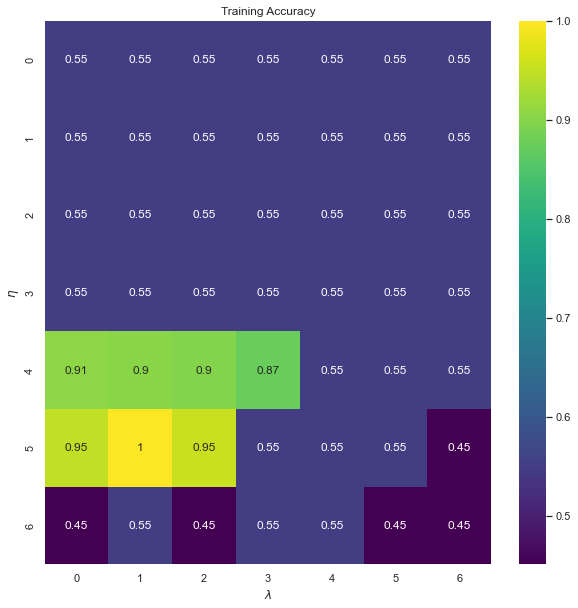

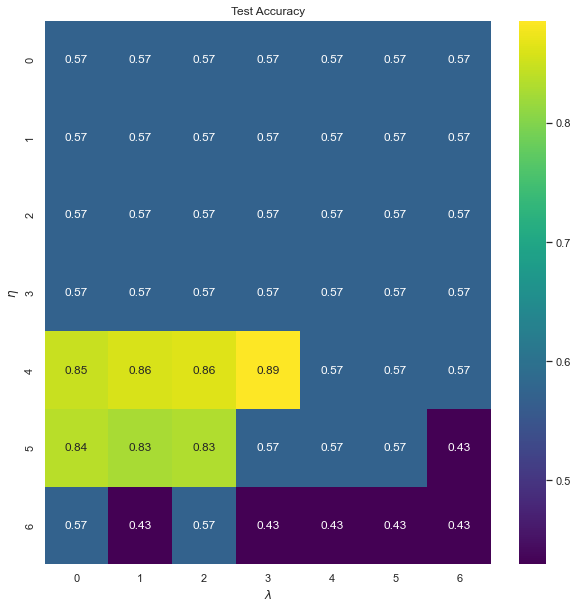

In [83]:
np.random.seed(100)
train_accuracy = np.zeros((len(lr), len(lmbd)))
test_accuracy = np.zeros((len(lr), len(lmbd)))

# grid search
for i, eta in enumerate(lr):
    for j, lm in enumerate(lmbd):
        # Instantiate the model
        model = Method()
        # Add layers
        model.add_to_list(Layer(20, 64, lmbd=lm))
        model.add_to_list(Activ_ReLU())
        model.add_to_list(Layer(64, 64, lmbd=lm))
        model.add_to_list(Activ_ReLU())
        model.add_to_list(Layer(64, 2))
        model.add_to_list(Activ_Softmax())
        
        # Set loss, optimizer and accuracy objects
        model.set_param(
            loss=Loss_CC(),
            optimiz=Optim_SGD(lr=eta, decay=5e-5, momentum=0.9),
            accuracy=Accuracy_Classification()
        )
        
        # Finalize the model
        model.finall()

        # Train the model
        train_acc, test_acc = model.fit(X_train_st, y_train_st, validation_data=(X_test_st, y_test_st), n_epoc=200)
        
        train_accuracy[i][j] = train_acc
        test_accuracy[i][j] = test_acc
        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

In [74]:
lr = np.logspace(-5, 1, 7)
lmbd = np.logspace(-5, 1, 7)
print(lr)
print(lmbd)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]
[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]


C:\Users\bod\AppData\Local\Temp/ipykernel_2336/148217150.py:239: RuntimeWarning: divide by zero encountered in true_divide
  self.grad_input = (-y_real/d_val)/sample
C:\Users\bod\AppData\Local\Temp/ipykernel_2336/148217150.py:239: RuntimeWarning: invalid value encountered in true_divide
  self.grad_input = (-y_real/d_val)/sample


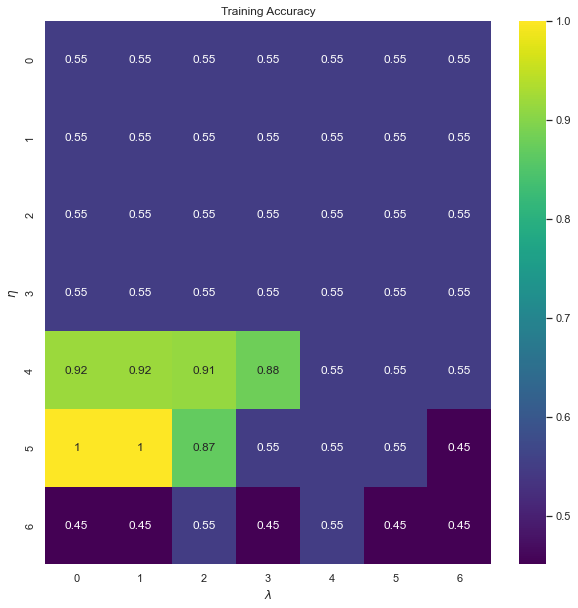

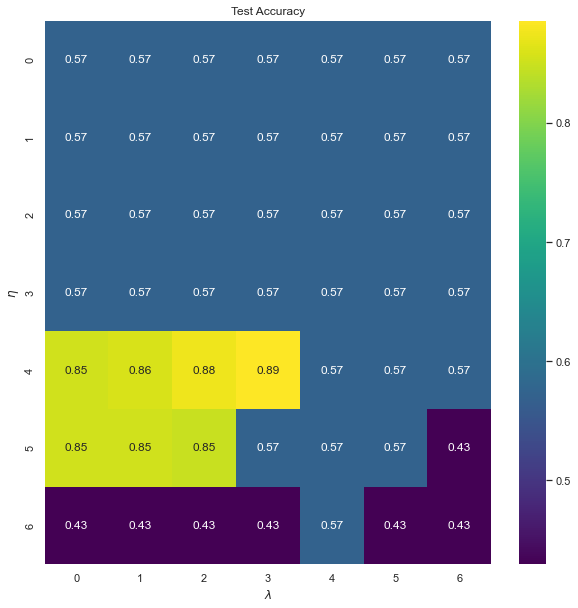

In [73]:
np.random.seed(100)
lr = np.logspace(-5, 1, 7)
lmbd = np.logspace(-5, 1, 7)

train_accuracy = np.zeros((len(lr), len(lmbd)))
test_accuracy = np.zeros((len(lr), len(lmbd)))

# grid search
for i, eta in enumerate(lr):
    for j, lm in enumerate(lmbd):
        # Instantiate the model
        model = Method()
        # Add layers
        model.add_to_list(Layer(20, 100, lmbd=lm))
        model.add_to_list(Activ_ReLU())
        model.add_to_list(Layer(100, 50, lmbd=lm))
        model.add_to_list(Activ_ReLU())
        model.add_to_list(Layer(50, 2))
        model.add_to_list(Activ_Softmax())
        
        # Set loss, optimizer and accuracy objects
        model.set_param(
            loss=Loss_CC(),
            optimiz=Optim_SGD(lr=eta, decay=5e-5, momentum=0.9),
            accuracy=Accuracy_Classification()
        )
        
        # Finalize the model
        model.finall()

        # Train the model
        train_acc, test_acc = model.fit(X_train_st, y_train_st, validation_data=(X_test_st, y_test_st), n_epoc=200)
        
        train_accuracy[i][j] = train_acc
        test_accuracy[i][j] = test_acc
        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

C:\Users\bod\AppData\Local\Temp/ipykernel_2336/148217150.py:239: RuntimeWarning: divide by zero encountered in true_divide
  self.grad_input = (-y_real/d_val)/sample
C:\Users\bod\AppData\Local\Temp/ipykernel_2336/148217150.py:239: RuntimeWarning: invalid value encountered in true_divide
  self.grad_input = (-y_real/d_val)/sample


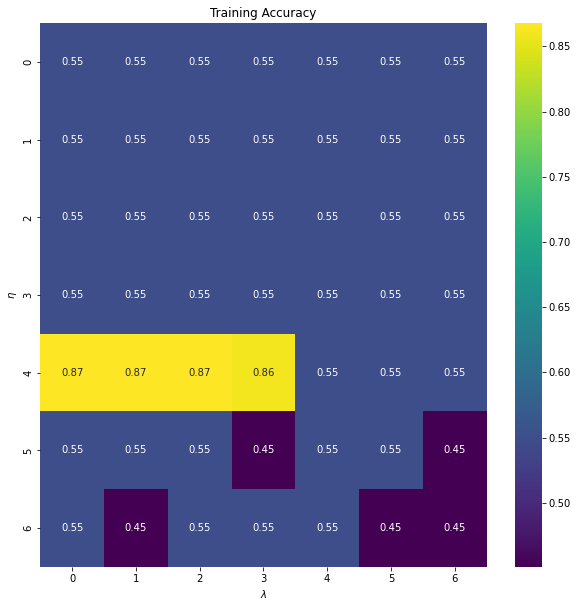

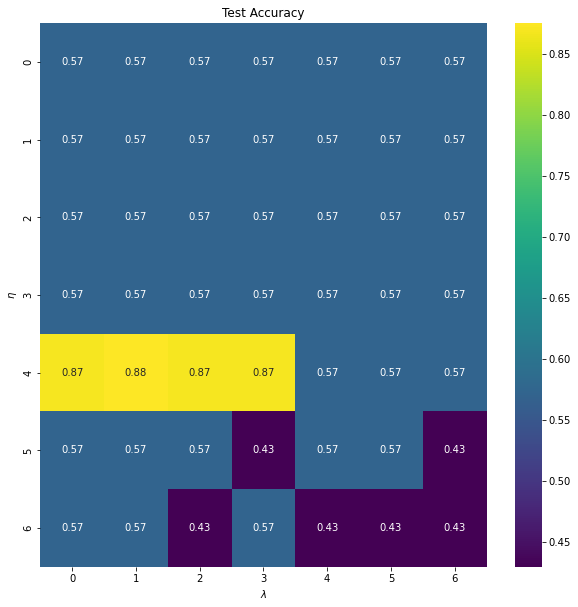

In [45]:
train_accuracy = np.zeros((len(lr), len(lmbd)))
test_accuracy = np.zeros((len(lr), len(lmbd)))

# grid search
for i, eta in enumerate(lr):
    for j, lm in enumerate(lmbd):
        # Instantiate the model
        model = Method()
        # Add layers
        model.add_to_list(Layer(20, 64, lmbd=lm))
        model.add_to_list(Activ_ReLU())
        model.add_to_list(Layer(64, 64, lmbd=lm))
        model.add_to_list(Activ_ReLU())
        model.add_to_list(Layer(64, 2))
        model.add_to_list(Activ_Softmax())
        
        # Set loss, optimizer and accuracy objects
        model.set_param(
            loss=Loss_CC(),
            optimiz=Optim_SGD(lr=eta, decay=5e-5, momentum=0.9),
            accuracy=Accuracy_Classification()
        )
        
        # Finalize the model
        model.finall()

        # Train the model
        train_acc, test_acc = model.fit(X_train_mm, y_train_mm, validation_data=(X_test_mm, y_test_mm), n_epoc=200)
        
        train_accuracy[i][j] = train_acc
        test_accuracy[i][j] = test_acc
        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

## The best combination of our own neural network

In [82]:
np.random.seed(100)
accuracy =[]


# Instantiate the model
model = Method()
# Add layers
model.add_to_list(Layer(20, 64, lmbd=0.01))
model.add_to_list(Activ_ReLU())
model.add_to_list(Layer(64, 64, lmbd=0.01))
model.add_to_list(Activ_ReLU())
model.add_to_list(Layer(64, 2))
model.add_to_list(Activ_Softmax())

# Set loss, optimizer and accuracy objects
model.set_param(
    loss=Loss_CC(),
    optimiz=Optim_SGD(lr=0.1, decay=5e-5, momentum=0.9),
    accuracy=Accuracy_Classification()
)

# Finalize the model
model.finall()

# Train the model
train_acc, test_acc = model.fit(X_train_st, y_train_st, validation_data=(X_test_st, y_test_st), n_epoc=200)

accuracy.append(train_acc)
accuracy.append(test_acc)


NN_result_df = pd.DataFrame({'Accuracy':accuracy}, index=['Train_acc', 'Test_acc'])
NN_result_df

,Accuracy
Train_acc,0.877384
Test_acc,0.885870


In [11]:
train_accuracy =[]
test_accuracy =[]
model_names =[]
variance = []
bias = []
MSE = []

#X= df.drop('HeartDisease', axis=1)
#y= df['HeartDisease']
X_train_oh, X_test_oh, y_train_oh, y_test_oh = train_test_split(X_oh, y, test_size=0.2, random_state=100)

X_train_oh=X_train_oh.values
X_test_oh=X_test_oh.values
y_train_oh=y_train_oh.values
y_test_oh=y_test_oh.values


#ohe= OneHotEncoder()
#s= StandardScaler()
#ct= make_column_transformer((ohe,categorical),(s,numerical))  

degree = range(0, 16)

for i in degree:
    model = SVC(degree = i, kernel = "poly", random_state=0)
    pipe = make_pipeline(StandardScaler(), model)
    #pipe.fit(X_train, y_train)
   # y_pred = pipe.predict(X_test)
    #test_accuracy.append(round(accuracy_score(y_test, y_pred),4))
   # train_accuracy.append(round(accuracy_score(y_train, pipe.predict(X_train)),4))
    
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        pipe, X_train_oh, y_train_oh, X_test_oh, y_test_oh, 
        loss='0-1_loss',
        random_seed=123,
        num_rounds=1000)
    MSE.append(avg_expected_loss) 
    variance.append(avg_var)
    bias.append(avg_bias)
    
    #print (f'model : {model} and  accuracy score is : {round(accuracy_score(y_test, y_pred),4)}')

#model_names = ['SVC']
#SVC_result_df = pd.DataFrame({'Accuracy':accuracy}, index=model_names)
#SVC_result_df

In [12]:
bias_2 = np.square(bias)

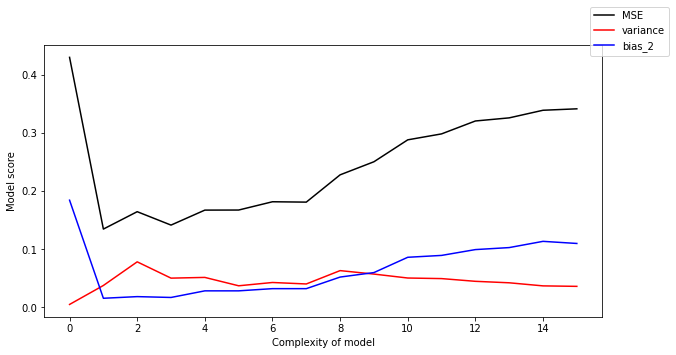

In [13]:
plt.figure(figsize=(10,5))
plt.xlabel('Complexity of model')
plt.ylabel('Model score')
plt.plot(degree, MSE, color = 'black', label = "MSE")
plt.plot(degree, variance, color = 'red', label = "variance")
plt.plot(degree, bias_2, color = 'blue', label = 'bias_2')
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.show()

In [7]:
from sklearn.linear_model import Lasso

a = np.logspace(-6, -1, 10)

variance = []
bias = []
MSE = []

X_train_oh, X_test_oh, y_train_oh, y_test_oh = train_test_split(X_oh, y, test_size=0.2, random_state=100)

X_train_oh=X_train_oh.values
X_test_oh=X_test_oh.values
y_train_oh=y_train_oh.values
y_test_oh=y_test_oh.values

for i in a:
    clf = Lasso(alpha=i)
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
            clf, X_train_oh, y_train_oh, X_test_oh, y_test_oh, 
            loss='0-1_loss',
            random_seed=123,
            num_rounds=1000)
    MSE.append(avg_expected_loss) 
    variance.append(avg_var)
    bias.append(avg_bias)

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.954e+00, tolerance: 1.830e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.136e+00, tolerance: 1.813e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.383e+00, tolerance: 1.820e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.492e+00, tolerance: 1.815e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.417e+00, tolerance: 1.758e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.580e+00, tolerance: 1.814e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.375e-01, tolerance: 1.828e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.325e+00, tolerance: 1.812e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.125e+00, tolerance: 1.802e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.567e+00, tolerance: 1.826e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.260e+00, tolerance: 1.804e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.258e+00, tolerance: 1.812e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.515e+00, tolerance: 1.820e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.898e+00, tolerance: 1.810e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.729e+00, tolerance: 1.813e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.328e+00, tolerance: 1.814e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.651e+00, tolerance: 1.805e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.718e+00, tolerance: 1.795e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.472e+00, tolerance: 1.784e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.984e+00, tolerance: 1.825e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.355e+00, tolerance: 1.828e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.773e+00, tolerance: 1.807e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.645e+00, tolerance: 1.812e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.988e+00, tolerance: 1.812e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.497e+00, tolerance: 1.812e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.628e+00, tolerance: 1.777e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.276e+00, tolerance: 1.826e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.841e+00, tolerance: 1.817e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.386e+00, tolerance: 1.807e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.136e+00, tolerance: 1.802e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.570e+00, tolerance: 1.831e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.838e+00, tolerance: 1.819e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.816e+00, tolerance: 1.824e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.970e-01, tolerance: 1.826e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.881e+00, tolerance: 1.820e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.142e+00, tolerance: 1.823e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.261e+00, tolerance: 1.779e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.015e+00, tolerance: 1.823e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.234e+00, tolerance: 1.827e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.528e+00, tolerance: 1.832e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.622e+00, tolerance: 1.828e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.985e+00, tolerance: 1.822e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.885e+00, tolerance: 1.828e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.410e+00, tolerance: 1.832e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.842e+00, tolerance: 1.817e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.146e+00, tolerance: 1.829e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.256e+00, tolerance: 1.819e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e+00, tolerance: 1.823e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.025e-02, tolerance: 1.831e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.264e-02, tolerance: 1.772e-02
  model = cd_fast.enet_coordinate_descent(
C:\Users\bod\anaconda3\envs\Liang\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

In [9]:
bias_2 = np.square(bias)

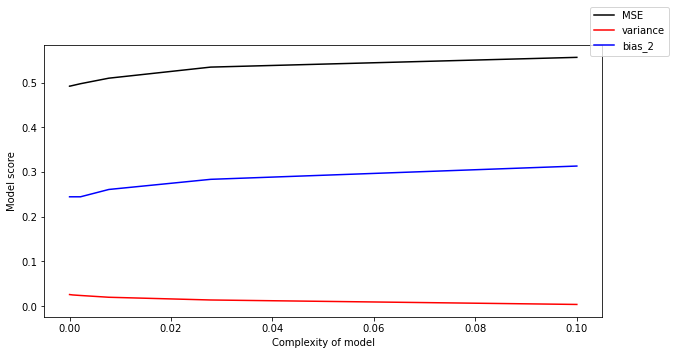

In [10]:
plt.figure(figsize=(10,5))
plt.xlabel('Complexity of model')
plt.ylabel('Model score')
plt.plot(a, MSE, color = 'black', label = "MSE")
plt.plot(a, variance, color = 'red', label = "variance")
plt.plot(a, bias_2, color = 'blue', label = 'bias_2')
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.show()

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

a = np.logspace(-6, -1, 10)

variance = []
bias = []
MSE = []

X_train_oh, X_test_oh, y_train_oh, y_test_oh = train_test_split(X_oh, y, test_size=0.2, random_state=100)

X_train_oh=X_train_oh.values
X_test_oh=X_test_oh.values
y_train_oh=y_train_oh.values
y_test_oh=y_test_oh.values

for i in a:
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, ccp_alpha = i, max_depth=1, random_state=0)
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
            clf, X_train_oh, y_train_oh, X_test_oh, y_test_oh, 
            loss='0-1_loss',
            random_seed=123,
            num_rounds=1000)
    MSE.append(avg_expected_loss) 
    variance.append(avg_var)
    bias.append(avg_bias)

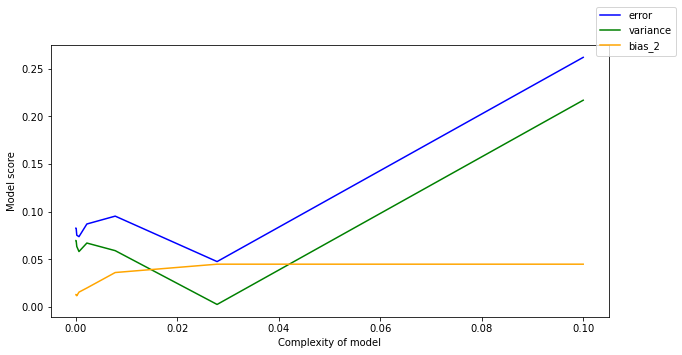

In [18]:
bias_2 = np.square(bias)
error = bias_2 + variance
plt.figure(figsize=(10,5))
plt.xlabel('Complexity of model')
plt.ylabel('Model score')
plt.plot(a, error, color = 'blue', label = "error")
plt.plot(a, variance, color = 'green', label = "variance")
plt.plot(a, bias_2, color = 'orange', label = 'bias_2')
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.show()

In [38]:
model = SVC()
mse, bias, var = bias_variance_decomp(model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, loss='mse', num_rounds=200, random_seed=1)

In [39]:
mse

0.30241847826086954

In [40]:
bias

0.2697536684782609

In [41]:
var

0.032664809782608696

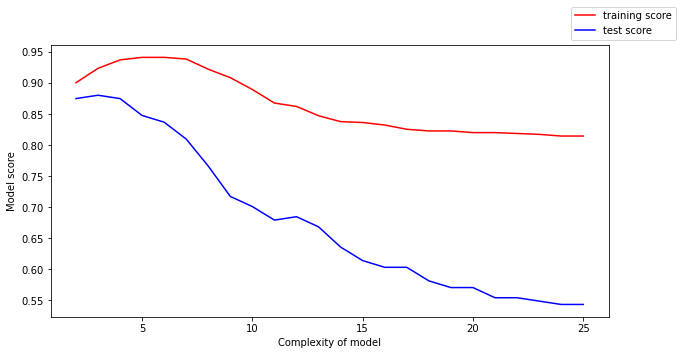

In [30]:
plt.figure(figsize=(10,5))
plt.xlabel('Complexity of model')
plt.ylabel('Model score')
plt.plot(degree, train_accuracy, color = 'r', label = "training score")
plt.plot(degree, test_accuracy, color = 'b', label = 'test score')
plt.legend(bbox_to_anchor=(1, 1),
           bbox_transform=plt.gcf().transFigure)
plt.show()

In [18]:
for i in degree: print(i)

2
3
4
5
6
7
8
9
10
11
12
13
14


[ 1.00067784  0.18314374 -1.02511698  0.79480966  0.        ]
Test MSE OLS
1.0258259290653717
0.001 [ 1.00072169  0.18262932 -1.02386114  0.7939879   0.        ]
0.001 [ 1.0020422  -0.10725096 -0.          0.          0.        ]
0.021544346900318832 [ 1.00159763  0.17234558 -0.99874772  0.77755218  0.        ]
0.021544346900318832 [ 0.92767265  0.         -0.         -0.          0.        ]
0.46415888336127775 [ 1.01320261  0.03374572 -0.65795393  0.55365986  0.        ]
0.46415888336127775 [0.48505811 0.         0.         0.         0.        ]
10.0 [ 1.01855698 -0.14492427 -0.11118531  0.1558751   0.        ]
10.0 [0. 0. 0. 0. 0.]


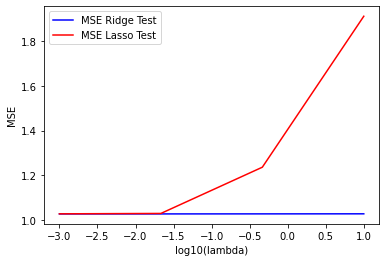

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model

def R2(y_data, y_model):
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model):
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

# Make data set.
n = 10000
x = np.random.rand(n)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.randn(n)

Maxpolydegree = 5
X = np.zeros((len(x),Maxpolydegree))
X[:,0] = 1.0

for polydegree in range(1, Maxpolydegree):
    for degree in range(polydegree):
        X[:,degree] = x**(degree)


# We split the data in test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# matrix inversion to find beta
OLSbeta = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train
print(OLSbeta)
ypredictOLS = X_test @ OLSbeta
print("Test MSE OLS")
print(MSE(y_test,ypredictOLS))
# Repeat now for Lasso and Ridge regression and various values of the regularization parameter using Scikit-Learn
# Decide which values of lambda to use
nlambdas = 4
MSERidgePredict = np.zeros(nlambdas)
MSELassoPredict = np.zeros(nlambdas)
lambdas = np.logspace(-3, 1, nlambdas)
for i in range(nlambdas):
    lmb = lambdas[i]
    # Make the fit using Ridge and Lasso
    RegRidge = linear_model.Ridge(lmb,fit_intercept=False)
    RegRidge.fit(X_train,y_train)
    RegLasso = linear_model.Lasso(lmb,fit_intercept=False)
    RegLasso.fit(X_train,y_train)
    # and then make the prediction
    ypredictRidge = RegRidge.predict(X_test)
    ypredictLasso = RegLasso.predict(X_test)
    # Compute the MSE and print it
    MSERidgePredict[i] = MSE(y_test,ypredictRidge)
    MSELassoPredict[i] = MSE(y_test,ypredictLasso)
    print(lmb,RegRidge.coef_)
    print(lmb,RegLasso.coef_)
# Now plot the results
plt.figure()
plt.plot(np.log10(lambdas), MSERidgePredict, 'b', label = 'MSE Ridge Test')
plt.plot(np.log10(lambdas), MSELassoPredict, 'r', label = 'MSE Lasso Test')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [12]:
#define Layers
"""Initializing for weights an biases for flexible number of layers with number of imputs and amount of neurons or hidden layers."""
class Layer():
    def __init__(self, n_features, neurons, lmbd = 0):
        # Initialize weights and biases
        self.n_features = n_features
        self.neurons = neurons
        self.weights = 0.01 * np.random.randn(self.n_features, self.neurons) #with normal distribution
        self.bias = np.zeros((1,self.neurons))

        # Set strength of regularization, the regularizer should be greater than or equal to 0
        self.weight_regularizer_l2 = lmbd

    def forward(self, inputs, train):
        self.input = inputs

        #Calculate output value from previous layer's inputs, weights and biases
        self.out = np.dot(inputs, self.weights) + self.bias

    def back(self, d_val):
        # gradients on weights and biases
        self.grad_weights = np.dot(self.input.T, d_val)
        self.grad_bias = np.sum(d_val, axis=0, keepdims=True)

        #L2 regularization on weights
        if self.weight_regularizer_l2 > 0:
            self.grad_weights += 2 * self.weight_regularizer_l2 * self.weights

        #Gradient on inputs
        self.grad_input = np.dot(d_val, self.weights.T)

class Layer_Input:
    def forward(self, inputs, train):
        self.out = inputs


'''Define activation function'''
class Activ_Sigmoid():
    def forward(self, inputs, train):
        self.input = inputs

        self.out =  1/(1 + np.exp(-inputs))
    def back(self, d_val):
        self.grad_input = d_val * (1 - self.out) * self.out

    def predict(self, out):
        return (out > 0.5) * 1

class Activ_Leaky_ReLU():
    def forward(self, inputs, train):
        self.input = inputs

        self.out = np.maximum(0.01 * inputs, inputs)

    def back(self, d_val):

        self.grad_input = d_val.copy()

        #gradient will be 0.01 when inputs are negative
        self.grad_input[self.input <= 0] = 0.01

    def predict(self, out):
        return out

class Activ_ReLU():
    def forward(self, inputs, train):
        self.input = inputs

        self.out = np.maximum(0, inputs)

    def back(self, d_val):

        self.grad_input = d_val.copy()

        #gradient will be 0 when inputs are negative
        self.grad_input[self.input <= 0] = 0

    def predict(self, out):
        return out

class Activ_Linear():
    def forward(self, inputs, train):
        self.input = inputs
        self.out = inputs

    def back(self, d_val):
        self.grad_input = d_val.copy()

    def predict(self, out):
        return out

class Activ_tanh():
    def forward(self, inputs, train):
        self.input = inputs

        self.out  = (np.exp(inputs) - np.exp(-inputs)) / (np.exp(inputs) + np.exp(-inputs))

    def back(self, d_val):
        self.grad_input = d_val.copy()

        self.grad_input = 1-self.out**2

    def predict(self, out):
        return out

class Activ_Softmax():

    def forward(self, inputs, train):
        self.input = inputs

        # Get unnormalized probabilities
        exp_val = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        # Normalize them for each sample
        probabilities = exp_val / np.sum(exp_val, axis=1, keepdims=True)

        self.out = probabilities

    def back(self, d_val):

        # Create uninitialized array
        self.grad_input = np.empty_like(d_val)

        # Enumerate outputs and gradients
        for index, (single_out, single_d_val) in enumerate(zip(self.out, d_val)):
            # Flatten output array
            single_out = single_out.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_out) - np.dot(single_out, single_out.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.grad_input[index] = np.dot(jacobian_matrix, single_d_val)

    def predict(self, out):
        return np.argmax(out, axis=1)

'''Define Optimizer'''
class Optim_SGD():

    def __init__(self, momentum = 0, decay = 0, lr = 1):
        self.momentum = momentum
        self.lr = lr
        self.decay = decay

        self.cur_lr = lr
        self.iter = 0

    def pre_up_par(self):
        if self.decay:
            self.cur_lr = self.lr * (1 / (1 + self.decay * self.iter))

    def up_par(self, layer):
        if self.momentum:
            #If layer dont consist of momentum we create them
            if not hasattr(layer, "weight_momentum"):
                layer.weight_momentum = np.zeros_like(layer.weights)
                layer.bias_momentum = np.zeros_like(layer.bias)

            #Creating weight updates
            weight_up = self.momentum * layer.weight_momentum - self.cur_lr * layer.grad_weights
            layer.weight_momentum = weight_up

            #Creating bias updates
            bias_up = self.momentum * layer.bias_momentum - self.cur_lr * layer.grad_bias
            layer.bias_momentum = bias_up

        else:
            weight_up = -self.cur_lr * layer.grad_weights

            bias_up = -self.cur_lr * layer.grad_bias


        layer.weights += weight_up
        layer.bias += bias_up

    def post_up_par(self):
        self.iter += 1

'''Define Loss'''
class Loss:

    def reg_loss(self):
        #initialize regularization loss
        reg_loss = 0

        #calculate regularization loss for each the training layer
        for layer in self.training_layer:
            # L2 regularization - weights
            if layer.weight_regularizer_l2 > 0:
                reg_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)

        return reg_loss

    def remember_training_layer(self, training_layer):
        self.training_layer = training_layer

    #calculate losses from data and regularization with model output and true values
    def cal(self, out, y, *, regularization=False):
        #loss from sample
        samp_loss = self.forward(out, y)
        #mean loss
        loss_dat = np.mean(samp_loss)

        if not regularization:
            return loss_dat

        return loss_dat, self.reg_loss()


# Categorical Cross-entropy loss
class Loss_CC(Loss):

    def forward(self, predict, y_real):
        #size of each batch
        sample = len(predict)

        # Clip data to avoid denominator of 0
        predict_clip = np.clip(predict, 1e-8, 1 - 1e-8)

        #Probabilities for target values of categorical labels
        if len(y_real.shape) == 1:
            cc = predict_clip[range(sample), y_real]

        elif len(y_real.shape) == 2:
            cc = np.sum(predict_clip * y_real, axis = 1)

        nll = -np.log(cc)
        return nll

    def back(self, d_val, y_real):

        sample = len(d_val)
        lab = len(d_val[0])

        if len(y_real.shape) == 1:
            y_real = np.eye(lab)[y_real]

        #Claculate and normalize
        self.grad_input = (-y_real/d_val)/sample

class Loss_MSE(Loss):

    def forwar(self, predict, y_real):
        samp_loss = np.mean((y_real - predict)**2, axis=-1)

        return samp_loss

    def backward(self, d_val, y_real):
        sample = len(d_val)

        out = len(d_val[0])

        #Claculate and normalize
        self.grad_input = (-2 * (y_real - d_val) / out) / sample

'''Define Accuracy'''
class Accuracy:

    def cal(self, predict, y):
        # Get comparison results
        comparisons = self.compare(predict, y)
        acc = np.mean(comparisons)

        return acc

    def cal_accum(self):

        acc = self.accum_sum / self.accum_count

        return acc

    # Reset variables for accumulated accuracy
    def reset_var(self):

        self.accum_sum = 0
        self.accum_count = 0


class Accuracy_Classification(Accuracy):

    def __init__(self, *, binary=False):
        # Binary mode?
        self.binary = binary

    def init(self, y):
        pass

    # Compares predictions to the ground truth values
    def compare(self, predict , y):

        if not self.binary and len(y.shape) == 2:
            y = np.argmax(y, axis = 1)

        return predict == y


class Accuracy_Regression(Accuracy):

    def __init__(self, y):
        self.precision = None

    def init(self, y, reinit=False):
        if self.precision is None or reinit:
            self.precision = np.std(y) / 250

    # Compares predictions to the ground truth values
    def compare(self, predict, y):
        return np.absolute(predict - y) < self.precision

'''Define Model'''
class Method():

    def __init__(self):
        self.layer = []
        self.train_acc = None
        self.test_acc = None

    def add_to_list(self, layer):
        self.layer.append(layer)

    def set_param(self, *, loss, accuracy, optimiz):
        self.optimiz = optimiz
        self.accuracy = accuracy
        self.loss = loss

    def finall(self):

        self.layer_inp = Layer_Input()
        layer_iter = len(self.layer)
        self.tlayer = []

        for i in range(layer_iter):

            if i == 0:
                self.layer[i].prev = self.layer_inp
                self.layer[i].next = self.layer[i+1]

            elif i < layer_iter - 1:
                self.layer[i].prev = self.layer[i-1]
                self.layer[i].next = self.layer[i+1]

            else:
                self.layer[i].prev = self.layer[i-1]
                self.layer[i].next = self.loss
                self.activ_out = self.layer[i]

            if hasattr(self.layer[i], "weights"):
                self.tlayer.append(self.layer[i])

        # Update loss object with trainable layers
        self.loss.remember_training_layer(self.tlayer)


    def fit(self, X, y, *, n_epoc = 1, validation_data = None, print_epoch = False):

        self.accuracy.init(y)

        for epochs in range(1, n_epoc+1):

            out = self.forward(X, train=True)

            loss_dat, reg_loss = self.loss.cal(out, y, regularization = True)
            loss = loss_dat + reg_loss

            predict = self.activ_out.predict(out) #??
            accuracy = self.accuracy.cal(predict, y)

            self.back(out, y)

            self.optimiz.pre_up_par()
            for layer in self.tlayer:
                self.optimiz.up_par(layer)
            self.optimiz.post_up_par()

            """
            if print_epoch:
                print(f'n_epoch: {epochs}, ' +
                      f'accuracy: {accuracy:.3f}, ' +
                      f'loss: {loss:.3f} (' +
                      f'loss in data: {loss_dat:.3f}, ' +
                      f'loss in reglarization: {reg_loss:.3f}), ' +
                      f'learningrate: {self.optimiz.cur_lr}')
            """

            if epochs == n_epoc:
                self.train_acc = accuracy


        if validation_data is not None:

            X_val, y_val = validation_data

            out = self.forward(X_val, train=False)

            loss = self.loss.cal(out, y_val)

            predict = self.activ_out.predict(out)

            accuracy = self.accuracy.cal(predict, y_val)

            self.test_acc = accuracy

            if print_epoch:
                print(f'validation, ' +
                      f'acc: {accuracy:.3f}, ' +
                      f'loss: {loss:.3f}')

        return self.train_acc, self.test_acc


    def forward(self, X, train):

        self.layer_inp.forward(X, train)

        for layer in self.layer:
            layer.forward(layer.prev.out, train)

        return layer.out

    def back(self, out, y):

        self.loss.back(out, y)

        for layer in reversed(self.layer):
            layer.back(layer.next.grad_input)